# Importing and Data Prep

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
from google.colab import drive
import pickle
from sklearn.utils import resample
import pandas as pd
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms
import numpy as np
from torch import nn

from sklearn.metrics import confusion_matrix
import seaborn as sn

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim #for gradient descent

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# install kaggle to access dataset
!pip install kaggle
# enable kaggle API
# note: you NEED to have your kaggle token saved in drive for this to work (https://github.com/Kaggle/kaggle-api)
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100));
os.chmod(filename, 600)
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
# download HASYV2 dataset
api.dataset_download_files('guru001/hasyv2')
# unzip data
!unzip hasyv2.zip

Streaming output truncated to the last 5000 lines.
  inflating: hasyv2/hasy-data/v2-95012.png  
  inflating: hasyv2/hasy-data/v2-95013.png  
  inflating: hasyv2/hasy-data/v2-95014.png  
  inflating: hasyv2/hasy-data/v2-95015.png  
  inflating: hasyv2/hasy-data/v2-95016.png  
  inflating: hasyv2/hasy-data/v2-95017.png  
  inflating: hasyv2/hasy-data/v2-95018.png  
  inflating: hasyv2/hasy-data/v2-95019.png  
  inflating: hasyv2/hasy-data/v2-95020.png  
  inflating: hasyv2/hasy-data/v2-95021.png  
  inflating: hasyv2/hasy-data/v2-95022.png  
  inflating: hasyv2/hasy-data/v2-95023.png  
  inflating: hasyv2/hasy-data/v2-95024.png  
  inflating: hasyv2/hasy-data/v2-95025.png  
  inflating: hasyv2/hasy-data/v2-95026.png  
  inflating: hasyv2/hasy-data/v2-95027.png  
  inflating: hasyv2/hasy-data/v2-95028.png  
  inflating: hasyv2/hasy-data/v2-95029.png  
  inflating: hasyv2/hasy-data/v2-95030.png  
  inflating: hasyv2/hasy-data/v2-95031.png  
  inflating: hasyv2/hasy-data/v2-95032.png  
  in

In [0]:
# creating own DatasetClass (this is like an ImageFolder, except custom so that we don't have to arrange images in a directory by label)
class SymbolsDataset(Dataset):
    def __init__(self, labels_path, imgs_path, indices, size):
        """
        Initialize data set as a list of IDs corresponding to each item of data set
        :param img_dir: path to image files as a uncompressed tar archive
        :param txt_path: a text file containing names of all of images line by line
        """
        # Read in the dataframe
        data = pd.read_csv(labels_path, sep=',', index_col=0)
        
        # Convert the column into a list
        master_list = []
        for i in range(168233):
          master_list.append(data.iloc[i, 1])

        # Extract just the unique values (i.e. the set)
        unique = np.unique(master_list)

        # Create a mapping between each symbol and an ID in [0,...,368]
        dict_id = {}
        i = 0
        for symbol in unique:
          dict_id[symbol] = i
          i = i + 1

        # Add an class_id column to represent the class for each
        data["class_id"] = 0

        # Iterate through the dataframe and add in the new id
        for i in range(168233):
          data.iloc[i, 3] = dict_id[data.iloc[i, 1]]

        # Finally, declare self.df
        self.df = data.iloc[indices,:] # use data, but only at relevant indices to either train/test/validate
        self.img_names = self.df.index.values
        self.labels_path = labels_path
        self.imgs_path = imgs_path
        #self.transform = transforms.Compose([transforms.ToTensor()])
        if size == 32:
          self.transform = transforms.Compose([transforms.ToTensor()])
        else: # Only normalize and resize and so forth if it's non-standard (i.e. not 32x32)
          self.transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor(), 
                                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def get_image_from_folder(self, name):
        """
        gets a image by a name gathered from file list text file
        :param name: name of targeted image
        :return: a PIL image
        """
        image = Image.open(os.path.join(self.imgs_path, name))
        return image

    def __len__(self):
        """
        Return the length of data set using list of IDs
        :return: number of samples in data set
        """
        return len(self.img_names)

    def __getitem__(self, index):
        """
        Generate one item of data set. 
        """
        img = self.get_image_from_folder(self.img_names[index])
        img = img.convert('L') 
        img = self.transform(img)
        #img = np.squeeze(img)
        #lbl = self.df.iloc[index][1]
        lbl = torch.tensor(self.df.iloc[index][3])

        return (img, lbl)

## Original

In [0]:
drive.mount('/content/drive', force_remount=True)
############### CHANGE BELOW PATH #################
# change the path that the .pkl files are in according to your directory

# With grayscale only
DATA_PATH = "/content/drive/My Drive/School/4th Year/APS 360 - Artificial Intelligence Fundamentals/APS 360 Project/Symbols Dataset (Balanced - 700 Classes) Greyscale/"
infile = open(DATA_PATH+'train_dataset_2_L.pkl','rb')
train_dataset = pickle.load(infile)
infile = open(DATA_PATH+'test_dataset_2_L.pkl','rb')
test_dataset = pickle.load(infile)
infile = open(DATA_PATH+'val_dataset_2_L.pkl','rb')
val_dataset = pickle.load(infile)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Double check size is same as below
# For new larger dataset (700/class):
tot = len(train_dataset) + len(val_dataset) + len(test_dataset)
print("Total number of records: ", tot)
delta = tot - 168233
print("There are now ", delta, " new records")

Total number of records:  258300
There are now  90067  new records


In [0]:
len(train_dataset)

154980

In [0]:
# Make data loader
# Create a dummy data loader for the purposes of printing some images
data_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=1)

In [0]:
# Define the loaders for the model training and testing
batch_size=128 # can change this

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [0]:
# Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim #for gradient descent

In [0]:
t = train_dataset.df

In [0]:
counts = t.groupby('class_id').count()
counts

,symbol_id,latex,user_id
class_id,,,
0,409,409,409
1,411,411,411
2,412,412,412
3,427,427,427
4,418,418,418
...,...,...,...
364,436,436,436
365,443,443,443
366,399,399,399


In [0]:
t

,symbol_id,latex,user_id,class_id
hasy-data/v2-106281.png,684,\varsubsetneq,16925,326
hasy-data/v2-109453.png,728,\leqslant,16925,161
hasy-data/v2-82125.png,530,\cap,16925,95
hasy-data/v2-140295.png,947,\diamondsuit,16925,120
hasy-data/v2-167337.png,1385,\O,16925,59
...,...,...,...,...
hasy-data/v2-161793.png,1086,\mathscr{L},16925,218
hasy-data/v2-20739.png,78,8,21606,11
hasy-data/v2-41620.png,163,\Lambda,16925,54
hasy-data/v2-162291.png,1090,\mathscr{P},16925,219


In [0]:
# display test images
# stolen from tutorial 3b
def show20(data):
    plt.figure(figsize=(10,2))
    for n, (img, label) in enumerate(data):
        if n >= 20:
            break
        plt.subplot(2, 10, n+1)
        # print(img.shape)
        img = np.squeeze(img)
        #print(img.shape)
        #img = img.permute(1, 2, 0)
        #print(img.shape)
        plt.imshow(img)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8cb916f518>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


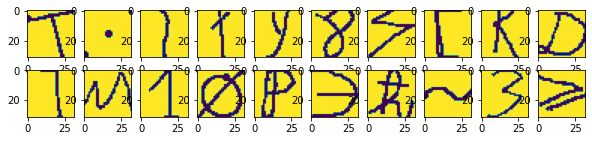

In [0]:
show20(data_loader)

## Dropped Classes Loading

In [0]:
drive.mount('/content/drive', force_remount=True)
############### CHANGE BELOW PATH #################
# change the path that the .pkl files are in according to your directory

# With grayscale only
DATA_PATH = "/content/drive/My Drive/School/4th Year/APS 360 - Artificial Intelligence Fundamentals/APS 360 Project/Greyscale Dropped Classes/"
infile = open(DATA_PATH+'train_dataset_L_dropped.pkl','rb')
train_dataset = pickle.load(infile)
infile = open(DATA_PATH+'test_dataset_L_dropped.pkl','rb')
test_dataset = pickle.load(infile)
infile = open(DATA_PATH+'val_dataset_L_dropped.pkl','rb')
val_dataset = pickle.load(infile)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Double check size is same as below
# For new larger dataset (700/class):
tot = len(train_dataset) + len(val_dataset) + len(test_dataset)
print("Total number of records: ", tot)
delta = tot - 168233
print("There are now ", delta, " new records")

Total number of records:  243600
There are now  75367  new records


In [0]:
len(train_dataset)

146160

In [0]:
# Define the loaders for the model training and testing
batch_size=128 # can change this

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [0]:
t = train_dataset.df

In [0]:
t

,symbol_id,latex,user_id,class_id
hasy-data/v2-18819.png,54,X,4142,38
hasy-data/v2-30811.png,112,w,15,344
hasy-data/v2-144624.png,958,\neg,16925,219
hasy-data/v2-12856.png,912,\langle,16925,145
hasy-data/v2-78448.png,520,\otimes,16925,237
...,...,...,...,...
hasy-data/v2-135272.png,923,\llbracket,16925,157
hasy-data/v2-154325.png,1031,\mathfrak{M},16925,198
hasy-data/v2-61957.png,190,\supset,16925,284
hasy-data/v2-17777.png,39,I,8486,23


In [0]:
counts = t.groupby('class_id').count()
counts

,symbol_id,latex,user_id
class_id,,,
0,404,404,404
1,426,426,426
2,435,435,435
3,417,417,417
4,409,409,409
...,...,...,...
343,431,431,431
344,434,434,434
345,417,417,417


# Functions

**Run everything in this section before proceeding to training / analysis**

## Training Functions

In [0]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [0]:
# Implement function for getting model accuracy

def get_accuracy(model, data_loader):
  '''
  Returns accuracy of the given model on the given dataset
  '''
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [0]:
# Implement function for getting model accuracy

def get_accuracy_no_GPU(model, data_loader):
  '''
  Specifies the get_accuracy function if not using GPU
  '''
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [0]:
# Define the training function

def train(model, train_loader, valid_loader, num_epochs=10, learning_rate=1e-3, weight_decay=0):
    '''
    Performs model training
    Saves the model's weights after every other training epoch
    This training function ASSUMES GPU usage
    Use train_no_GPU if training on CPU
    '''

    torch.manual_seed(21)
    # Use cross-entropy loss for this multi-class classification task
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Declare arrays to store accuracy measures
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    # Below, we will track accuracy and loss on a per epoch basis

    print("Training started...")
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        i = 0

        for imgs, labels in iter(train_loader):

            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
              
            #print(imgs.shape)
            out = model(imgs)             # forward pass
            #print(labels)   
            #print(out) 
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            i = i + 1

            total_train_loss = total_train_loss + loss.item()

        # Compute the average train loss for this epoch
        avg_train_loss = total_train_loss/i

        # Add this avg loss to the tracker
        train_loss.append(avg_train_loss)

        j = 0
        # Compute loss validation set as well
        for imgs, labels in iter(valid_loader):
            
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)
            loss = criterion(out, labels)
            j = j + 1

            total_val_loss = total_val_loss + loss.item()

        # Compute the average validation loss for this epoch
        avg_val_loss = total_val_loss/j

        # Add this avg loss to the tracker
        val_loss.append(avg_val_loss)

        # Report the losses
        print('Epoch #{}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, float(avg_train_loss), float(avg_val_loss)))

        # Store the accuracies for this epoch
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, valid_loader))
        print("Epoch #{}, Training Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, train_acc[-1], val_acc[-1]))

        # Save the model every 3 epochs
        #if epoch%2 == 0:
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    epoch_set = range(num_epochs)

    plt.title("Training vs. Validation Accuracy")
    plt.plot(epoch_set, train_acc, label="Train")
    plt.plot(epoch_set, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Training vs. Validation Loss")
    plt.plot(epoch_set, train_loss, label="Train")
    plt.plot(epoch_set, val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()  

In [0]:
# Define the training function

def train_no_GPU(model, train_loader, valid_loader, num_epochs=10, learning_rate=1e-3, weight_decay=0):

    torch.manual_seed(21)
    # Use cross-entropy loss for this multi-class classification task
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Declare arrays to store accuracy measures
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    # Below, we will track accuracy and loss on a per epoch basis

    print("Training started...")
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        i = 0

        for imgs, labels in iter(train_loader):

            # if use_cuda and torch.cuda.is_available():
            #     imgs = imgs.cuda()
            #     labels = labels.cuda()
              
            #print(imgs.shape)
            out = model(imgs)             # forward pass 
            #print(labels)   
            #print(out)      
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            i = i + 1

            total_train_loss = total_train_loss + loss.item()

        # Compute the average train loss for this epoch
        avg_train_loss = total_train_loss/i

        # Add this avg loss to the tracker
        train_loss.append(avg_train_loss)

        j = 0
        # Compute loss validation set as well
        for imgs, labels in iter(valid_loader):
            
            # if use_cuda and torch.cuda.is_available():
            #     imgs = imgs.cuda()
            #     labels = labels.cuda()

            out = model(imgs)
            loss = criterion(out, labels)
            j = j + 1

            total_val_loss = total_val_loss + loss.item()

        # Compute the average validation loss for this epoch
        avg_val_loss = total_val_loss/j

        # Add this avg loss to the tracker
        val_loss.append(avg_val_loss)

        # Report the losses
        print('Epoch #{}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, float(avg_train_loss), float(avg_val_loss)))

        # Store the accuracies for this epoch
        train_acc.append(get_accuracy_no_GPU(model, train_loader))
        val_acc.append(get_accuracy_no_GPU(model, valid_loader))
        print("Epoch #{}, Training Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, train_acc[-1], val_acc[-1]))

        # Save the model every 3 epochs
        if epoch%2 == 0:
          model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
          torch.save(model.state_dict(), model_path)

    epoch_set = range(num_epochs)

    plt.title("Training vs. Validation Accuracy")
    plt.plot(epoch_set, train_acc, label="Train")
    plt.plot(epoch_set, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Training vs. Validation Loss")
    plt.plot(epoch_set, train_loss, label="Train")
    plt.plot(epoch_set, val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()  

## Analysis Functions

In [0]:
def prepare_full_accuracy(model, data_loader):
    '''
    Inputs: final model (i.e. trained weights) and data loader
    Note that this should be the validation or test loader
    Outputs: Based on the model and the validation / test set, it returns
    two lists: full_labels_list is a list of all of the true labels while
    full_pred_list is a list of all the corresponding predictions of the model
    Necessary to execute this for other analysis functions
    '''

    full_labels_list = []
    full_pred_list = []

    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        
        mini_labels_list = []
        for i in range(len(labels)):
          mini_labels_list.append(int(labels[i]))

        full_labels_list.extend(mini_labels_list)

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]

        mini_pred_list = []
        for j in range(len(pred)):
          mini_pred_list.append(int(pred[j]))

        full_pred_list.extend(mini_pred_list)

    return full_labels_list, full_pred_list

In [0]:
def full_accuracy_totals(y_true, y_pred):
  '''
  Inputs: Full lists of the actual labels and the predictions from prepare_full_accuracy()
  Returns: a dictionary with a mapping between each symbol and its: (1) prediction accuracy
  in the validation set, (2) total number of correct predictions, (3) total number of appearances.
  For prediction accuracy, this will report:
  In all cases where the symbol X was the true label, what % of the time did
  the model get it right
  '''
  master_dict = {}
  # First, get a set representation of y_true
  unique = np.unique(y_true)

  # Loop through unique
  for symbol in unique:
    # For each symbol, we will loop through all of y_true
    num_correct = 0
    total_instances = 0
    for i in range(len(y_true)):
      # Stop once we reach an element that matches the symbol
      if y_true[i] == symbol:
        # Increment total instances by 1
        total_instances += 1
        # Next, check to see if the corresponding prediction was correct 
        if y_true[i] == y_pred[i]:
          num_correct += 1
    # At the end of the loop compute and store num_correct, total, and accuracy
    accuracy = round(num_correct / total_instances, 4)
    latex = get_symbol_LATEX(symbol, val_dataset)
    master_dict[symbol] = (accuracy, num_correct, total_instances, latex)
    #master_dict[symbol] = (latex, accuracy, num_correct, total_instances)

  return master_dict

In [0]:
def get_accuracy_symbol(master_dict, symbol_id):
  '''
  Assumes input of the master dictionary generated by full_accuracy_totals
  Returns accuracy for a given symbol
  '''

  return master_dict[symbol_id][0]

In [0]:
import operator

def plot_accuracy(master_dict, acc):
  '''
  Input: results dictionary
  Output: produces a bar chart plot of overall accuracy for each class, and also sorted
  '''
  symbol_id_vals = []
  accuracy_vals = []

  # First, just plot it regularly (no sorting)
  for symbol in master_dict:
    symbol_id_vals.append(symbol)
    # Note that accuracy % is stored at position 0 in each entry
    accuracy_vals.append(master_dict[symbol][0])

  plt.title("Test Accuracy by Symbol")
  plt.bar(symbol_id_vals, accuracy_vals)
  plt.xlabel("Symbol Class")
  plt.ylabel("Test Accuracy")
  plt.show()

  # Get a sorted version of the dictionary
  sort_dict = sorted(master_dict.items(), key=operator.itemgetter(1))
  sorted_symbols = []
  sorted_acc = []
  # Iterate through and prep vectors for plotting
  for num in range(len(sort_dict)):
    sorted_symbols.append(sort_dict[num][0])
    sorted_acc.append(sort_dict[num][1][0])

  # Turn symbols list into strings
  sorted_symbols = [str(i) for i in sorted_symbols]
  plt.title("Sorted Test Accuracy by Symbol")
  plt.bar(sorted_symbols, sorted_acc)
  plt.xlabel ("Symbol Class")
  plt.ylabel("Test Accuracy")
  plt.axhline(y=acc, xmin=0, xmax=347, color='r', linestyle='-')
  plt.show()


In [0]:
import operator

def plot_X_accuracy(master_dict, X, direction):
  '''
  Plots the top/bottom X symbols and returns a list of their corresponding symbol ID's
  master_dict: dictionary containing full details on accuracy for each symbol 
  X: an integer indicating how many symbols you want to show
  direction: either "Top" or "Bottom" indicating which end of the distribution you want
  Note: also returns a list of symbol id's; can be easily used with get_symbol_LATEX to find
  which symbols the ID's represent
  '''
  # Get a sorted version of the dictionary
  sort_dict = sorted(master_dict.items(), key=operator.itemgetter(1))
  sorted_symbols = []
  sorted_acc = []
  # Iterate through and prep vectors for plotting
  for num in range(len(sort_dict)):
    sorted_symbols.append(sort_dict[num][0])
    sorted_acc.append(sort_dict[num][1][0])

  # Turn symbols list into strings
  sorted_symbols = [str(i) for i in sorted_symbols]

  if direction == "Bottom":
    true_sorted_symbols = sorted_symbols[0:X+1]
    true_sorted_acc = sorted_acc[0:X+1]
  if direction == "Top":
    true_sorted_symbols = sorted_symbols[-1*X:]
    true_sorted_acc = sorted_acc[-1*X:]
    
  plt.title("{} {} Symbols: Test Accuracy by Symbol".format(direction, X))
  plt.bar(true_sorted_symbols, true_sorted_acc)
  plt.xlabel ("Symbol Class")
  plt.ylabel("Test Accuracy")
  plt.show()

  # Before returning the symbols themselves, convert them back into ints
  true_sorted_symbols = [int(i) for i in true_sorted_symbols]

  return true_sorted_symbols

In [0]:
def get_symbol_LATEX(sym_id, dataset_obj):
  '''
  Retreives the LaTeX equivalent name for a symbol, given its ID
  # Note: look-up is based on *class_id* in the dataset
  '''
  df = dataset_obj.df

  for i in range(df.shape[0]):
    if df.iloc[i, 3] == sym_id:
      return df.iloc[i, 1] 
  
  return None

In [0]:
def get_LATEX(latex, dataset_obj):
  df = dataset_obj.df

  for i in range(df.shape[0]):
    if df.iloc[i, 1] == latex:
      return df.iloc[i, 3] 
    
  return None

In [0]:
def sort_dictionary(master_dict):
  '''
  Input: results dictionary
  Output: returns the same dictionary, but sorted from lowest to highest accuracy
  '''
  sorted_list = sorted(master_dict.items(), key=lambda x: x[1])
  #sorted_list = sorted(master_dict.items(), key=lambda x: x[4])
  return sorted_list

In [0]:
def get_single_confusion(confusion, sym_id):
  '''
  Input: the confusion matrix and the numerical id for the symbol of interest
  Output: confusion analysis for that symbol
  '''
  
  print("\nThis symbol is: ", get_symbol_LATEX(sym_id, train_dataset))
  print("\nConfusion analysis:\n")

  nonzero_symbols = []
  
  size = confusion.shape[0]
  for j in range(size):
    value = confusion[sym_id][j]
    if value > 0:
      #symbols_map[j] = value
      nonzero_symbols.append(j)
  
  # Get the corresponding names
  names_list = []
  for num in nonzero_symbols:
    names_list.append(get_symbol_LATEX(num, train_dataset))
  
  # Finally, create a dictionary that is: name --> percentage
  return_dict = {}
  for i in range(len(nonzero_symbols)):
    return_dict[names_list[i]] = round(confusion[sym_id][nonzero_symbols[i]], 4)
    
  print(return_dict)
  return return_dict


# Old Model Iterations

## 5-Layer CNN Architecture

In [0]:
class CNN_Deeper_v1(nn.Module):
    def __init__(self):
        super(CNN_Deeper_v1, self).__init__()
        self.name = "Compact"
        self.conv1 = nn.Conv2d(1, 16, 3)   # Note: Only one input channel (gray scale)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 100, 3)
        self.conv5 = nn.Conv2d(100, 160, 3)

        self.fc1 = nn.Linear(160 * 3 * 3, 75)
        self.fc2 = nn.Linear(75, 369)

    def forward(self, img):
        x = F.relu(self.conv1(img))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))

        x = x.view(-1, 160 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
class CNN_Deeper_v2(nn.Module):
    def __init__(self):
        super(CNN_Deeper_v2, self).__init__()
        self.name = "More_Conv2"
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)   # Note: Only one input channel (gray scale)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.conv6 = nn.Conv2d(256, 340, 2)  #Might have to make a smaller kernel here (2x2?)

        self.fc1 = nn.Linear(340 * 2 * 2, 65)
        self.fc2 = nn.Linear(65, 369)

    def forward(self, img):
        x = F.relu(self.conv1(img))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        x = x.view(-1, 340 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
deeper_model = CNN_Deeper_v2()
use_cuda = True
deeper_model.cuda()

CNN_Deeper_v2(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 340, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=1360, out_features=65, bias=True)
  (fc2): Linear(in_features=65, out_features=369, bias=True)
)

In [0]:
train(deeper_model, train_loader, validation_loader, num_epochs=40, learning_rate=0.001)

Training started...
Epoch #0, Training Loss: 3.2013, Validation Loss: 1.7218
Epoch #0, Training Accuracy: 0.5369, Validation Accuracy: 0.5338
Epoch #1, Training Loss: 1.4146, Validation Loss: 1.2448
Epoch #1, Training Accuracy: 0.6435, Validation Accuracy: 0.6339
Epoch #2, Training Loss: 1.0907, Validation Loss: 1.0442
Epoch #2, Training Accuracy: 0.6974, Validation Accuracy: 0.6804
Epoch #3, Training Loss: 0.9270, Validation Loss: 0.9579
Epoch #3, Training Accuracy: 0.7246, Validation Accuracy: 0.7015
Epoch #4, Training Loss: 0.8169, Validation Loss: 0.9067
Epoch #4, Training Accuracy: 0.7454, Validation Accuracy: 0.7190
Epoch #5, Training Loss: 0.7360, Validation Loss: 0.8652
Epoch #5, Training Accuracy: 0.7605, Validation Accuracy: 0.7292
Epoch #6, Training Loss: 0.6743, Validation Loss: 0.8359
Epoch #6, Training Accuracy: 0.7747, Validation Accuracy: 0.7412
Epoch #7, Training Loss: 0.6185, Validation Loss: 0.8238
Epoch #7, Training Accuracy: 0.7822, Validation Accuracy: 0.7437
Epoc

KeyboardInterrupt: ignored

In [0]:
deep_model = CNN_Deeper_v1()
use_cuda = True
deep_model.cuda()

CNN_Deeper_v1(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(100, 160, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1440, out_features=75, bias=True)
  (fc2): Linear(in_features=75, out_features=369, bias=True)
)

Training started...
Epoch #0, Training Loss: 3.0370, Validation Loss: 1.6711
Epoch #0, Training Accuracy: 0.5561, Validation Accuracy: 0.5491
Epoch #1, Training Loss: 1.3793, Validation Loss: 1.2552
Epoch #1, Training Accuracy: 0.6520, Validation Accuracy: 0.6408
Epoch #2, Training Loss: 1.0946, Validation Loss: 1.0627
Epoch #2, Training Accuracy: 0.6973, Validation Accuracy: 0.6826
Epoch #3, Training Loss: 0.9616, Validation Loss: 0.9698
Epoch #3, Training Accuracy: 0.7205, Validation Accuracy: 0.7043
Epoch #4, Training Loss: 0.8766, Validation Loss: 0.9037
Epoch #4, Training Accuracy: 0.7391, Validation Accuracy: 0.7195
Epoch #5, Training Loss: 0.8127, Validation Loss: 0.8571
Epoch #5, Training Accuracy: 0.7548, Validation Accuracy: 0.7333
Epoch #6, Training Loss: 0.7606, Validation Loss: 0.8354
Epoch #6, Training Accuracy: 0.7629, Validation Accuracy: 0.7394
Epoch #7, Training Loss: 0.7196, Validation Loss: 0.8180
Epoch #7, Training Accuracy: 0.7700, Validation Accuracy: 0.7437
Epoc

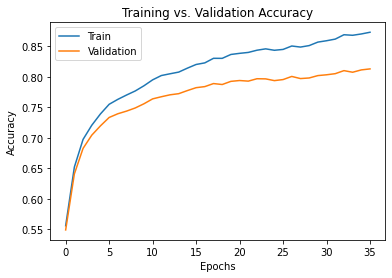

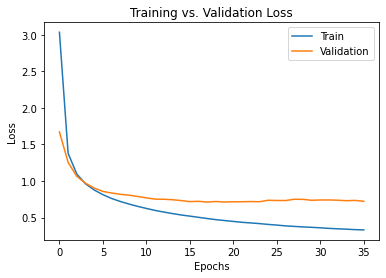

In [0]:
train(deep_model, train_loader, validation_loader, num_epochs=36, learning_rate=0.001)

Okay, this looks pretty solid. Validation loss is flat while validation accuracy was still increasing...

In fact, it was making strong gains towards the end there. We can try picking up and continuing training, but overall, this looks like it could benefit from further training epochs!

In [0]:
train(deep_model, train_loader, validation_loader, num_epochs=20, learning_rate=0.001)

Training started...
Epoch #0, Training Loss: 0.3261, Validation Loss: 0.7493
Epoch #0, Training Accuracy: 0.8673, Validation Accuracy: 0.8084
Epoch #1, Training Loss: 0.3210, Validation Loss: 0.7488
Epoch #1, Training Accuracy: 0.8710, Validation Accuracy: 0.8126
Epoch #2, Training Loss: 0.3159, Validation Loss: 0.7440
Epoch #2, Training Accuracy: 0.8766, Validation Accuracy: 0.8148
Epoch #3, Training Loss: 0.3119, Validation Loss: 0.7500
Epoch #3, Training Accuracy: 0.8761, Validation Accuracy: 0.8134
Epoch #4, Training Loss: 0.3063, Validation Loss: 0.7549
Epoch #4, Training Accuracy: 0.8787, Validation Accuracy: 0.8175
Epoch #5, Training Loss: 0.3027, Validation Loss: 0.7569
Epoch #5, Training Accuracy: 0.8758, Validation Accuracy: 0.8158
Epoch #6, Training Loss: 0.2966, Validation Loss: 0.7703
Epoch #6, Training Accuracy: 0.8747, Validation Accuracy: 0.8128
Epoch #7, Training Loss: 0.2944, Validation Loss: 0.7601


In [0]:
# let's do v1 again, but this time, keep the model the same as the other notebook's run
# The only difference therefore will be the fact that this is grayscale data

class CNN_Deeper_Ref(nn.Module):
    def __init__(self):
        super(CNN_Deeper_Ref, self).__init__()
        self.name = "Reference"
        self.conv1 = nn.Conv2d(1, 16, 3)   # Note: Only one input channel (gray scale)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 100, 3)
        self.conv5 = nn.Conv2d(100, 160, 3)

        self.fc1 = nn.Linear(160 * 3 * 3, 80)
        self.fc2 = nn.Linear(80, 369)

    def forward(self, img):
        x = F.relu(self.conv1(img))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))

        x = x.view(-1, 160 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
model_ref = CNN_Deeper_Ref()
use_cuda = True
model_ref.cuda()

CNN_Deeper_Ref(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(100, 160, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1440, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=369, bias=True)
)

In [0]:
train_no_GPU(model_ref, train_loader, validation_loader, num_epochs=50, learning_rate=0.001)

Training started...
Epoch #0, Training Loss: 2.8073, Validation Loss: 1.4857
Epoch #0, Training Accuracy: 0.5937, Validation Accuracy: 0.5899
Epoch #1, Training Loss: 1.2675, Validation Loss: 1.1193
Epoch #1, Training Accuracy: 0.6797, Validation Accuracy: 0.6694
Epoch #2, Training Loss: 1.0179, Validation Loss: 0.9944
Epoch #2, Training Accuracy: 0.7128, Validation Accuracy: 0.6958
Epoch #3, Training Loss: 0.8985, Validation Loss: 0.9297
Epoch #3, Training Accuracy: 0.7312, Validation Accuracy: 0.7127
Epoch #4, Training Loss: 0.8229, Validation Loss: 0.8796
Epoch #4, Training Accuracy: 0.7455, Validation Accuracy: 0.7259
Epoch #5, Training Loss: 0.7658, Validation Loss: 0.8342
Epoch #5, Training Accuracy: 0.7629, Validation Accuracy: 0.7399
Epoch #6, Training Loss: 0.7174, Validation Loss: 0.7977
Epoch #6, Training Accuracy: 0.7754, Validation Accuracy: 0.7501
Epoch #7, Training Loss: 0.6772, Validation Loss: 0.7687
Epoch #7, Training Accuracy: 0.7866, Validation Accuracy: 0.7585
Epoc

KeyboardInterrupt: ignored

Overall, this looks EXTREMELY similar to the original run with RGB...except for some reason, it take smuch longer to "warm up" initially. This might just be due to random weight initialization, but this training curve is about 5 epochs behind the original, despite the lower complexity with grayscale.

Training started...
Epoch #0, Training Loss: 2.8216, Validation Loss: 1.4675
Epoch #0, Training Accuracy: 0.5987, Validation Accuracy: 0.5922
Epoch #1, Training Loss: 1.2213, Validation Loss: 1.1217
Epoch #1, Training Accuracy: 0.6770, Validation Accuracy: 0.6681
Epoch #2, Training Loss: 0.9820, Validation Loss: 0.9722
Epoch #2, Training Accuracy: 0.7191, Validation Accuracy: 0.7024
Epoch #3, Training Loss: 0.8618, Validation Loss: 0.8790
Epoch #3, Training Accuracy: 0.7483, Validation Accuracy: 0.7287
Epoch #4, Training Loss: 0.7778, Validation Loss: 0.8372
Epoch #4, Training Accuracy: 0.7607, Validation Accuracy: 0.7368
Epoch #5, Training Loss: 0.7130, Validation Loss: 0.8001
Epoch #5, Training Accuracy: 0.7738, Validation Accuracy: 0.7469
Epoch #6, Training Loss: 0.6586, Validation Loss: 0.7726
Epoch #6, Training Accuracy: 0.7857, Validation Accuracy: 0.7550
Epoch #7, Training Loss: 0.6122, Validation Loss: 0.7502
Epoch #7, Training Accuracy: 0.7971, Validation Accuracy: 0.7643
Epoc

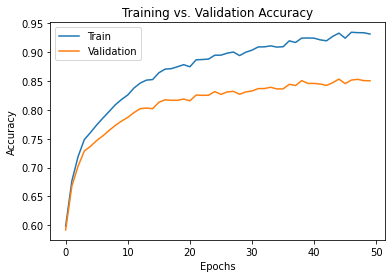

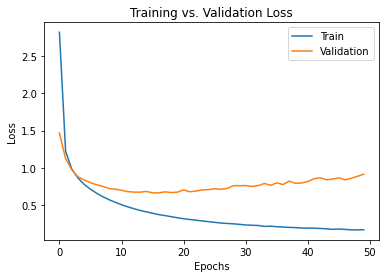

In [0]:
# Full run for 50 epochs - expect to see similar results
# Idea here is to see how long validation accuracy will keep increasing
train(model_ref, train_loader, validation_loader, num_epochs=50, learning_rate=0.001)

Use early stopping here at epoch #38 for the result portion

### Results Analysis

In [0]:
# Define the model path via early stopping
# Based on training, pick the model epoch that is best
# Check the files section on Colab to ensure that the model was saved for that epoch

# Things to change:
# 1) The model (1st parameter)
# 2) The epoch # (depends on where your best model was during training)
# batch size and learning rate, if you changed those parameters

path_test = get_model_name(model_ref.name, batch_size=128, learning_rate=0.001, epoch=36)

In [0]:
# Load this older model's weights
# ALSO: Change the model class (i.e. "CNN_Deeper_v1()") to your model's class
# Easiest to just leave the name of the variable as "model" for the rest of this

# Instantiate a new empty model
model = CNN_Deeper_Ref() 
# Load in its weights
model.load_state_dict(torch.load(path_test))
# RUN THIS STEP IF USING GPU
model.cuda()
model.eval()

CNN_Deeper_Ref(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(100, 160, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1440, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=369, bias=True)
)

In [0]:
# Take a peak at out of sample results...
get_accuracy(model, test_loader)

0.8441347270615563

In [0]:
# Generate predictions
true_states, pred_states = prepare_full_accuracy(model, validation_loader)

In [0]:
# Get results dictionary
all_accuracy_dict = full_accuracy_totals(true_states, pred_states)

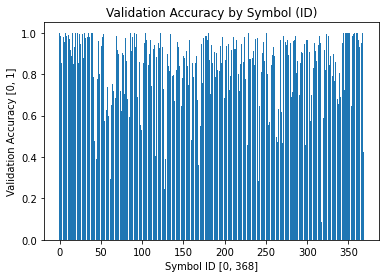

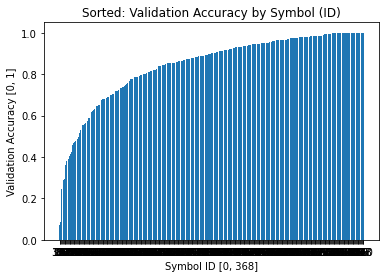

In [0]:
# Plot accuracy by class
plot_accuracy(all_accuracy_dict)

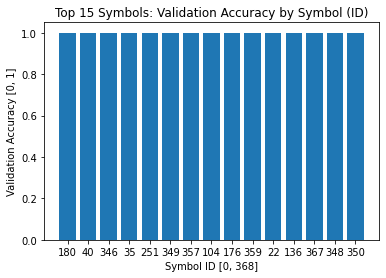

In [0]:
# Plot the top X classes --> leave at 15 for readability
best = plot_X_accuracy(all_accuracy_dict, 15, "Top")

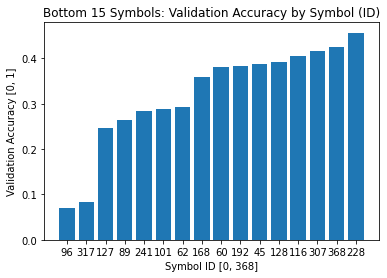

In [0]:
# Get the worst X classes --> leave at 15 for readability
worst = plot_X_accuracy(all_accuracy_dict, 15, "Bottom")

In [0]:
# Sort and display all results by accuracy
sort_dictionary(all_accuracy_dict)

[(96, (0.0692, 9, 130)),
 (317, (0.0844, 13, 154)),
 (127, (0.2462, 32, 130)),
 (89, (0.2647, 36, 136)),
 (241, (0.2847, 39, 137)),
 (101, (0.2878, 40, 139)),
 (62, (0.2933, 44, 150)),
 (168, (0.3597, 50, 139)),
 (60, (0.3819, 55, 144)),
 (192, (0.384, 48, 125)),
 (45, (0.3878, 57, 147)),
 (128, (0.3916, 56, 143)),
 (116, (0.4048, 51, 126)),
 (307, (0.4152, 71, 171)),
 (368, (0.4247, 62, 146)),
 (228, (0.4566, 79, 173)),
 (298, (0.46, 69, 150)),
 (270, (0.4662, 69, 148)),
 (264, (0.4718, 67, 142)),
 (42, (0.4759, 69, 145)),
 (175, (0.4769, 62, 130)),
 (160, (0.4806, 62, 129)),
 (67, (0.4889, 66, 135)),
 (263, (0.4965, 70, 141)),
 (318, (0.518, 72, 139)),
 (99, (0.5294, 90, 170)),
 (124, (0.5455, 78, 143)),
 (171, (0.5479, 80, 146)),
 (98, (0.5556, 70, 126)),
 (253, (0.5563, 79, 142)),
 (49, (0.5573, 73, 131)),
 (255, (0.563, 76, 135)),
 (254, (0.569, 66, 116)),
 (304, (0.5726, 67, 117)),
 (54, (0.5735, 78, 136)),
 (73, (0.5897, 92, 156)),
 (320, (0.5899, 82, 139)),
 (85, (0.5912, 81, 1

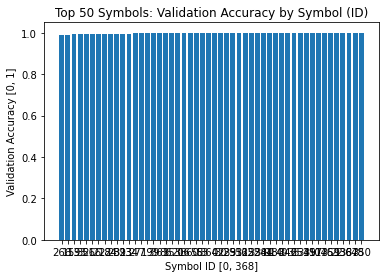

In [0]:
# Run this to faciliate later code
best = plot_X_accuracy(all_accuracy_dict, 50, "Top")

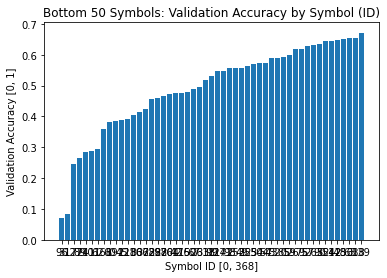

In [0]:
# Run this to faciliate later code
worst = plot_X_accuracy(all_accuracy_dict, 50, "Bottom")

In [0]:
# Print names of top 50 symbols
for i in best:
  print(get_symbol_LATEX(i, train_dataset))

\rangle
8
\L
\boxtimes
n
\mathscr{F}
G
N
J
\sqsubseteq
\varpi
\flat
M
4
E
Y
s
\between
k
F
B
r
\Leftarrow
\barwedge
w
+
P
\nearrow
i
j
x
\doteq
p
b
\boxdot
\mathbb{Z}
Z
d
U
\parr
g
o
\circledR
\mathbb{H}
q
H
\frown
z
f
h


In [0]:
# Print names of bottom 50 symbols
for j in worst:
  print(get_symbol_LATEX(j, train_dataset))

\cdot
\vDash
\emptyset
\bot
\o
\circ
\Pi
\longrightarrow
\Omega
\mathcal{O}
\&
\epsilon
\degree
\triangle
|
\nabla
\sum
\rightarrow
\propto
\#
\mathbb{1}
\leq
\Sigma
\prod
\varepsilon
\checkmark
\dotsc
\male
\checked
\perp
\Delta
\pi
\phi
\theta
\Lambda
\aleph
\varnothing
\beta
\O
\rho
\amalg
\Longleftrightarrow
\psi
\bowtie
l
\odot
\in
\parallel
\Psi
\zeta
\geq


In [0]:
# Generate confusion matrix
matrix = confusion_matrix(true_states, pred_states, normalize='true')

In [0]:
# Output confusion analysis for each of the 50 worst symbols
for i in worst:
  get_single_confusion(matrix, i)


This symbol is:  \cdot

Confusion analysis:

{'-': 0.0077, '\\backslash': 0.0077, '\\bullet': 0.0769, '\\cdot': 0.0692, '\\ddots': 0.0231, '\\dotsc': 0.8077, 'p': 0.0077}

This symbol is:  \vDash

Confusion analysis:

{'H': 0.0065, '\\angle': 0.0065, '\\coprod': 0.0065, '\\dashv': 0.0065, '\\lfloor': 0.0065, '\\longmapsto': 0.0065, '\\mapsfrom': 0.0065, '\\models': 0.7922, '\\nvDash': 0.0195, '\\rightleftarrows': 0.0065, '\\sigma': 0.013, '\\sqcap': 0.0065, '\\tau': 0.0065, '\\vDash': 0.0844, '\\vdash': 0.0065, '\\xi': 0.0195}

This symbol is:  \emptyset

Confusion analysis:

{'\\O': 0.1231, '\\Phi': 0.0077, '\\degree': 0.0077, '\\delta': 0.0154, '\\diameter': 0.0923, '\\div': 0.0077, '\\emptyset': 0.2462, '\\mathds{N}': 0.0077, '\\mathds{Q}': 0.0154, '\\mathfrak{A}': 0.0077, '\\o': 0.0692, '\\parr': 0.0077, '\\phi': 0.1462, '\\rrbracket': 0.0077, '\\varnothing': 0.2308, '\\varpi': 0.0077}

This symbol is:  \bot

Confusion analysis:

{'L': 0.0074, '\\bot': 0.2647, '\\coprod': 0.0074, 

Weird Symbol Identification

In [0]:
# Now, let's look up the ID's of the "weird" symbols that don't apply to our application
get_LATEX("\clubsuit", train_dataset)

107

In [0]:
get_LATEX("\leftmoon", val_dataset)

158

In [0]:
get_LATEX("\fullmoon", val_dataset)

In [0]:
array = ['\clubsuit', '\copyright', '\diamond', '\diamondsuit', '\heartsuit',
         '\lozenge', '\guillemotleft', '\star', '\male', '\\female', '\\venus',
         '\\fullmoon', '\leftmoon', '\sun']

weird_symb_id = []
for latex in array:
  sym_id = get_LATEX(latex, val_dataset)
  print("For ", latex, ", ID is: ", sym_id)
  weird_symb_id.append(sym_id)

For  \clubsuit , ID is:  107
For  \copyright , ID is:  110
For  \diamond , ID is:  119
For  \diamondsuit , ID is:  120
For  \heartsuit , ID is:  145
For  \lozenge , ID is:  169
For  \guillemotleft , ID is:  143
For  \star , ID is:  292
For  \male , ID is:  171
For  \female , ID is:  132
For  \venus , ID is:  332
For  \fullmoon , ID is:  137
For  \leftmoon , ID is:  158
For  \sun , ID is:  299


In [0]:
get_LATEX('\circledR', val_dataset)

104

In [0]:
# Print out the corresponding accuracy for these:
for i in weird_symb_id:
  print(all_accuracy_dict[i])

(0.8497, 130, 153)
(0.9653, 139, 144)
(0.8676, 118, 136)
(0.9517, 138, 145)
(0.8409, 111, 132)
(0.8696, 120, 138)
(0.9542, 146, 153)
(0.8521, 121, 142)
(0.5479, 80, 146)
(0.8406, 116, 138)
(0.8973, 131, 146)
(0.7895, 105, 133)
(0.9688, 124, 128)
(0.9636, 159, 165)


Analysis of Semantically Same Symbols

In [0]:
# Construct array of relevant confusion symbols
# These are symbols where there is ZERO physical difference
# Instead, there is a semantic difference between the two that is impossible to pick up

#watch out for \f and \v"
confused = [['\\bowtie', '\Bowtie'], ['\|', '\parallel'], ['\\bot', '\perp'],
            ['\lhd', '\\triangleleft'], ['\\amalg', '\coprod'], ['\mid', '|'],
            ['\prod', '\Pi'], ['\dotsc', '\dots'], ['\ohm', '\Omega'],
            ['\sum', '\Sigma'], ['\S', '\mathsection']]

#for word in confused:
  

In [0]:
for i in confused:
  print(i)

['\\bowtie', '\\Bowtie']
['\\|', '\\parallel']
['\\bot', '\\perp']
['\\lhd', '\\triangleleft']
['\\amalg', '\\coprod']
['\\mid', '|']
['\\prod', '\\Pi']
['\\dotsc', '\\dots']
['\\ohm', '\\Omega']
['\\sum', '\\Sigma']
['\\S', '\\mathsection']


In [0]:
for pair in confused:
  first = pair[0]
  second = pair[1]
  first_ID = get_LATEX(first, val_dataset)
  second_ID = get_LATEX(second, val_dataset)
  print("Symbol 1: ", first, " with ID: ", first_ID)
  print(first, " Accuracy: ", all_accuracy_dict[first_ID])
  print("Symbol 2: ", second, " with ID: ", second_ID)
  print(second, " Accuracy: ", all_accuracy_dict[second_ID])
  get_single_confusion(matrix, first_ID)
  get_single_confusion(matrix, second_ID)
  print("\n")

Symbol 1:  \bowtie  with ID:  90
\bowtie  Accuracy:  (0.6333, 76, 120)
Symbol 2:  \Bowtie  with ID:  48
\Bowtie  Accuracy:  (0.8027, 118, 147)

This symbol is:  \bowtie

Confusion analysis:

{'\\Bowtie': 0.2333, '\\bowtie': 0.6333, '\\cap': 0.0083, '\\infty': 0.0167, '\\leqslant': 0.0083, '\\ltimes': 0.0833, '\\mathscr{A}': 0.0083, '\\otimes': 0.0083}

This symbol is:  \Bowtie

Confusion analysis:

{'\\Bowtie': 0.8027, '\\bowtie': 0.0816, '\\ltimes': 0.0884, '\\mathcal{M}': 0.0068, '\\mathds{N}': 0.0136, '\\triangleleft': 0.0068}


Symbol 1:  \|  with ID:  340
\|  Accuracy:  (0.6879, 97, 141)
Symbol 2:  \parallel  with ID:  250
\parallel  Accuracy:  (0.6496, 89, 137)

This symbol is:  \|

Confusion analysis:

{'1': 0.0071, '\\parallel': 0.2979, '\\sqcup': 0.0071, '\\|': 0.6879}

This symbol is:  \parallel

Confusion analysis:

{'N': 0.0073, '\\%': 0.0073, '\\amalg': 0.0073, '\\mathds{N}': 0.0073, '\\nu': 0.0073, '\\parallel': 0.6496, '\\phi': 0.0073, '\\sqcup': 0.0073, '\\|': 0.2993}



Finally, a brief analysis on the ones that are just weird and not necessary (continuation of the first one)

In [0]:
waste = ['\mathscr{A}', '\mathscr{C}', '\mathscr{D}', '\mathscr{E}',
         '\mathscr{F}', '\mathscr{H}', '\mathscr{L}', '\mathscr{P}', '\mathscr{S}']

In [0]:
for i in waste:
  sym_id = get_LATEX(i, val_dataset)
  print(i, " IDL: ", sym_id)
  print("Accuracy: ", all_accuracy_dict[sym_id])
  print("\n")

\mathscr{A}  IDL:  212
Accuracy:  (0.9195, 137, 149)


\mathscr{C}  IDL:  213
Accuracy:  (0.922, 130, 141)


\mathscr{D}  IDL:  214
Accuracy:  (0.9667, 145, 150)


\mathscr{E}  IDL:  215
Accuracy:  (0.9504, 134, 141)


\mathscr{F}  IDL:  216
Accuracy:  (0.9932, 146, 147)


\mathscr{H}  IDL:  217
Accuracy:  (0.7987, 119, 149)


\mathscr{L}  IDL:  218
Accuracy:  (0.7206, 98, 136)


\mathscr{P}  IDL:  219
Accuracy:  (0.8467, 116, 137)


\mathscr{S}  IDL:  220
Accuracy:  (0.9467, 142, 150)




In [0]:
weird = [['\pi', '\\varpi'], ['\\rho', '\\varrho'], ['\phi', '\\varphi'], ['\\theta', '\\vartheta']]

In [0]:
for i in weird:
  print(i)

['\\pi', '\\varpi']
['\\rho', '\\varrho']
['\\phi', '\\varphi']
['\\theta', '\\vartheta']


In [0]:
for pair in weird:
  first = pair[0]
  second = pair[1]
  first_ID = get_LATEX(first, val_dataset)
  second_ID = get_LATEX(second, val_dataset)
  print("Symbol 1: ", first, " with ID: ", first_ID)
  print(first, " Accuracy: ", all_accuracy_dict[first_ID])
  print("Symbol 2: ", second, " with ID: ", second_ID)
  print(second, " Accuracy: ", all_accuracy_dict[second_ID])
  get_single_confusion(matrix, first_ID)
  get_single_confusion(matrix, second_ID)
  print("\n")

Symbol 1:  \pi  with ID:  255
\pi  Accuracy:  (0.563, 76, 135)
Symbol 2:  \varpi  with ID:  323
\varpi  Accuracy:  (0.9938, 159, 160)

This symbol is:  \pi

Confusion analysis:

{'\\Omega': 0.0074, '\\Pi': 0.2222, '\\Sigma': 0.0074, '\\barwedge': 0.0148, '\\boxdot': 0.0074, '\\curvearrowright': 0.0074, '\\eta': 0.0074, '\\gamma': 0.0074, '\\hbar': 0.0148, '\\mathcal{T}': 0.0074, '\\mathds{Z}': 0.0074, '\\mathscr{C}': 0.0074, '\\mp': 0.0074, '\\pi': 0.563, '\\prod': 0.0815, '\\rtimes': 0.0074, '\\sharp': 0.0074, '\\tau': 0.0074, 'p': 0.0074}

This symbol is:  \varpi

Confusion analysis:

{'\\ohm': 0.0062, '\\varpi': 0.9938}


Symbol 1:  \rho  with ID:  269
\rho  Accuracy:  (0.617, 87, 141)
Symbol 2:  \varrho  with ID:  325
\varrho  Accuracy:  (0.863, 126, 146)

This symbol is:  \rho

Confusion analysis:

{'8': 0.0071, 'P': 0.0142, 'R': 0.0071, '\\Gamma': 0.0142, '\\beta': 0.0496, '\\fint': 0.0142, '\\mathcal{L}': 0.0071, '\\mathcal{P}': 0.0142, '\\mathcal{S}': 0.0071, '\\mathscr{S}': 0.

In [0]:
a = "\\triangledown"
b = "\\nabla"

a_id = get_LATEX(a, val_dataset)
b_id = get_LATEX(b, val_dataset)

print(all_accuracy_dict[a_id])
print(all_accuracy_dict[b_id])

cap = get_single_confusion(matrix, a_id)
cap = get_single_confusion(matrix, b_id)

(0.8295, 107, 129)
(0.4566, 79, 173)

This symbol is:  \triangledown

Confusion analysis:

{'\\Omega': 0.0155, '\\forall': 0.0078, '\\nabla': 0.1473, '\\triangledown': 0.8295}

This symbol is:  \nabla

Confusion analysis:

{'\\degree': 0.0058, '\\gamma': 0.0058, '\\mathscr{F}': 0.0058, '\\nabla': 0.4566, '\\triangledown': 0.5202, '\\triangleleft': 0.0058}


Getting a mapping of id --> latex 

In [0]:
v = val_dataset.df

In [0]:
v

,symbol_id,latex,user_id,class_id
hasy-data/v2-163814.png,1111,\venus,16925,332
hasy-data/v2-111973.png,753,\Rightarrow,16925,65
hasy-data/v2-152245.png,1007,\mathcal{O},16925,192
hasy-data/v2-163779.png,1111,\venus,16925,332
hasy-data/v2-130548.png,901,\nexists,16925,232
...,...,...,...,...
hasy-data/v2-148815.png,974,\varnothing,16925,320
hasy-data/v2-65078.png,193,\cong,16925,108
hasy-data/v2-114127.png,764,\Leftarrow,16925,55
hasy-data/v2-80799.png,527,\bullet,16925,94


In [0]:
col = v.class_id

In [0]:
len(col)

51660

In [0]:
unique = np.unique(col)

In [0]:
latex_dict = {}

In [0]:
for i in unique:
  latex = get_symbol_LATEX(i, val_dataset)
  latex_dict[i] = latex

In [0]:
latex_dict

{0: '+',
 1: '-',
 2: '/',
 3: '0',
 4: '1',
 5: '2',
 6: '3',
 7: '4',
 8: '5',
 9: '6',
 10: '7',
 11: '8',
 12: '9',
 13: '<',
 14: '>',
 15: 'A',
 16: 'B',
 17: 'C',
 18: 'D',
 19: 'E',
 20: 'F',
 21: 'G',
 22: 'H',
 23: 'I',
 24: 'J',
 25: 'K',
 26: 'L',
 27: 'M',
 28: 'N',
 29: 'O',
 30: 'P',
 31: 'Q',
 32: 'R',
 33: 'S',
 34: 'T',
 35: 'U',
 36: 'V',
 37: 'W',
 38: 'X',
 39: 'Y',
 40: 'Z',
 41: '[',
 42: '\\#',
 43: '\\$',
 44: '\\%',
 45: '\\&',
 46: '\\AA',
 47: '\\AE',
 48: '\\Bowtie',
 49: '\\Delta',
 50: '\\Downarrow',
 51: '\\Gamma',
 52: '\\Im',
 53: '\\L',
 54: '\\Lambda',
 55: '\\Leftarrow',
 56: '\\Leftrightarrow',
 57: '\\Longleftrightarrow',
 58: '\\Longrightarrow',
 59: '\\O',
 60: '\\Omega',
 61: '\\Phi',
 62: '\\Pi',
 63: '\\Psi',
 64: '\\Re',
 65: '\\Rightarrow',
 66: '\\S',
 67: '\\Sigma',
 68: '\\Theta',
 69: '\\Vdash',
 70: '\\Xi',
 71: '\\aa',
 72: '\\ae',
 73: '\\aleph',
 74: '\\alpha',
 75: '\\amalg',
 76: '\\angle',
 77: '\\approx',
 78: '\\ast',
 79: '\\a

In [0]:
# Some accuracy values of interest
array = [42, 54, 64, 84, 13, 14, 47, 115, 117, 245, 244, 149, 255, 288, 304, 252]

for i in array:
  print(get_symbol_LATEX(i, val_dataset), ": ", all_accuracy_dict[i])

\# :  (0.4759, 69, 145)
\Lambda :  (0.5735, 78, 136)
\Re :  (0.7518, 103, 137)
\because :  (0.9467, 160, 169)
< :  (0.9167, 121, 132)
> :  (0.888, 111, 125)
\AE :  (0.9621, 127, 132)
\ddots :  (0.9429, 132, 140)
\delta :  (0.8839, 137, 155)
\oint :  (0.8113, 129, 159)
\oiint :  (0.8769, 114, 130)
\infty :  (0.7805, 96, 123)
\pi :  (0.563, 76, 135)
\sqrt{} :  (0.863, 126, 146)
\theta :  (0.5726, 67, 117)
\partial :  (0.8, 112, 140)


In [0]:
cap = get_single_confusion(matrix, 54)
cap = get_single_confusion(matrix, 42)
cap = get_single_confusion(matrix, 64)
cap = get_single_confusion(matrix, array[9])
cap = get_single_confusion(matrix, array[11])
cap = get_single_confusion(matrix, array[12])
cap = get_single_confusion(matrix, array[13])
cap = get_single_confusion(matrix, array[14])
cap = get_single_confusion(matrix, array[15])


This symbol is:  \Lambda

Confusion analysis:

{'A': 0.0074, '\\Delta': 0.0294, '\\Lambda': 0.5735, '\\cap': 0.0074, '\\lambda': 0.0147, '\\ohm': 0.0074, '\\vartriangle': 0.0515, '\\wedge': 0.3088}

This symbol is:  \#

Confusion analysis:

{'4': 0.0069, '\\#': 0.4759, '\\forall': 0.0069, '\\mathcal{H}': 0.0138, '\\mathscr{F}': 0.0069, '\\mathscr{H}': 0.0069, '\\nRightarrow': 0.0069, '\\notin': 0.0069, '\\nvDash': 0.0069, '\\oiint': 0.0207, '\\prod': 0.0069, '\\sharp': 0.3931, '\\sigma': 0.0069, '\\star': 0.0069, '\\succ': 0.0069, '\\sun': 0.0069, '\\uplus': 0.0138}

This symbol is:  \Re

Confusion analysis:

{'R': 0.0219, '\\%': 0.0146, '\\Re': 0.7518, '\\ae': 0.0073, '\\female': 0.0073, '\\mathcal{H}': 0.0073, '\\mathcal{R}': 0.0657, '\\mathds{E}': 0.0073, '\\mathds{R}': 0.0949, '\\star': 0.0146, '\\wp': 0.0073}

This symbol is:  \oint

Confusion analysis:

{'\\$': 0.0063, '\\Phi': 0.0377, '\\S': 0.0126, '\\bullet': 0.0063, '\\emptyset': 0.0063, '\\iddots': 0.0063, '\\int': 0.0126, 

## With Batch Norm Before Activation

In [0]:
# let's do v1 again, but this time, keep the model the same as the other notebook's run
# The only difference therefore will be the fact that this is grayscale data

class CNN_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_BatchNorm, self).__init__()
        self.name = "BatchNorm"
        self.conv1 = nn.Conv2d(1, 16, 3)   # Note: Only one input channel (gray scale)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 100, 3)
        self.conv5 = nn.Conv2d(100, 160, 3)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(100)
        self.bn5 = nn.BatchNorm2d(160)
        self.bn_FC = nn.BatchNorm1d(80)

        self.fc1 = nn.Linear(160 * 3 * 3, 80)
        self.fc2 = nn.Linear(80, 369)

    def forward(self, img):
        x = F.relu(self.bn1(self.conv1(img)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))

        x = x.view(-1, 160 * 3 * 3)
        x = F.relu(self.bn_FC(self.fc1(x)))
        x = self.fc2(x)
        return x

In [0]:
model_BN = CNN_BatchNorm()
use_cuda = True
model_BN.cuda()

CNN_BatchNorm(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(100, 160, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1440, out_features=80, bias

In [0]:
model_BN.train()

CNN_BatchNorm(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(100, 160, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1440, out_features=80, bias

Training started...
Epoch #0, Training Loss: 1.7948, Validation Loss: 0.8359
Epoch #0, Training Accuracy: 0.7593, Validation Accuracy: 0.7399
Epoch #1, Training Loss: 0.6839, Validation Loss: 0.6577
Epoch #1, Training Accuracy: 0.8140, Validation Accuracy: 0.7832
Epoch #2, Training Loss: 0.5185, Validation Loss: 0.5781
Epoch #2, Training Accuracy: 0.8484, Validation Accuracy: 0.8089
Epoch #3, Training Loss: 0.4111, Validation Loss: 0.5324
Epoch #3, Training Accuracy: 0.8716, Validation Accuracy: 0.8262
Epoch #4, Training Loss: 0.3342, Validation Loss: 0.5109
Epoch #4, Training Accuracy: 0.8905, Validation Accuracy: 0.8374
Epoch #5, Training Loss: 0.2757, Validation Loss: 0.5007
Epoch #5, Training Accuracy: 0.9027, Validation Accuracy: 0.8429
Epoch #6, Training Loss: 0.2313, Validation Loss: 0.4973
Epoch #6, Training Accuracy: 0.9151, Validation Accuracy: 0.8515
Epoch #7, Training Loss: 0.1974, Validation Loss: 0.5083
Epoch #7, Training Accuracy: 0.9216, Validation Accuracy: 0.8540
Epoc

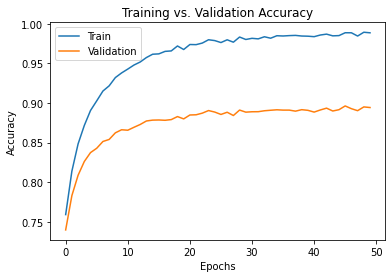

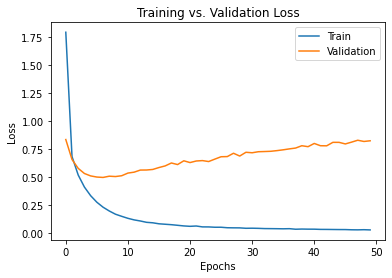

In [0]:
train(model_BN, train_loader, validation_loader, num_epochs=50, learning_rate=0.001)

We will apply early stopping to epoch #22, which is where it hits ~88.7% accuracy.

Going by the validation LOSS to apply early stopping, we would go with ~ epoch #8, which gives 86.2%.

SO that's about a 2.5% difference in accuracy, with a tradeoff of ~0.13 in loss, which isn't trivial.

### Results

In [0]:
path_test = get_model_name(model_BN.name, batch_size=128, learning_rate=0.001, epoch=22)

In [0]:
path_test_loss = get_model_name(model_BN.name, batch_size=128, learning_rate=0.001, epoch=8)

In [0]:
# Instantiate a new empty model
model = CNN_BatchNorm() 
# Load in its weights
model.load_state_dict(torch.load(path_test))
# RUN THIS STEP IF USING GPU
model.cuda()
model.eval()

CNN_BatchNorm(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(100, 160, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1440, out_features=80, bias

In [0]:
get_accuracy(model, test_loader)

0.8879984514130855

In [0]:
# Instantiate a new empty model
model_loss = CNN_BatchNorm() 
# Load in its weights
model_loss.load_state_dict(torch.load(path_test_loss))
model_loss.cuda()
model_loss.eval()

CNN_BatchNorm(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(100, 160, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1440, out_features=80, bias

In [0]:
get_accuracy(model_loss, test_loader)

0.8654471544715447

In [0]:
true_states, pred_states = prepare_full_accuracy(model, validation_loader)

In [0]:
true_states_loss, pred_states_loss = prepare_full_accuracy(model_loss, validation_loader)

In [0]:
all_accuracy_dict = full_accuracy_totals(true_states, pred_states)

In [0]:
all_accuracy_dict_loss = full_accuracy_totals(true_states_loss, pred_states_loss)

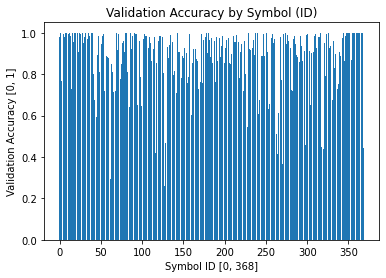

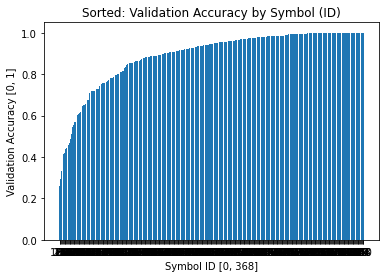

In [0]:
plot_accuracy(all_accuracy_dict)

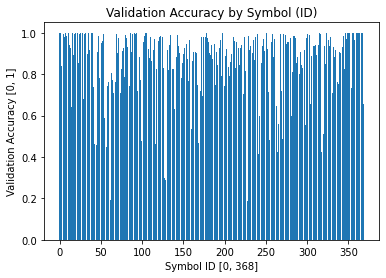

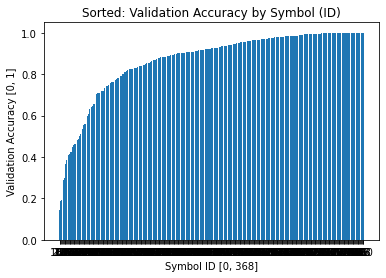

In [0]:
plot_accuracy(all_accuracy_dict_loss)

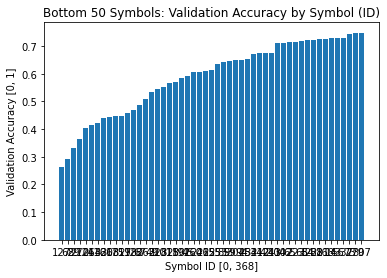

In [0]:
worst = plot_X_accuracy(all_accuracy_dict, 50, "Bottom")

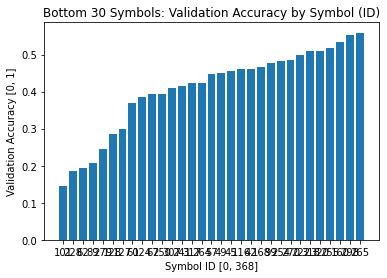

In [0]:
worst_loss = plot_X_accuracy(all_accuracy_dict_loss, 30, "Bottom")

In [0]:
for i in worst:
  print(get_symbol_LATEX(i, val_dataset))

\emptyset
\Pi
\bot
\rightarrow
\dotsc
\propto
\degree
\varnothing
|
\mathbb{1}
\vDash
\sum
\epsilon
\Sigma
\prod
\Delta
\nabla
\circ
\varepsilon
\parallel
\mathcal{O}
\&
\leq
\o
\psi
\pi
\perp
\beta
\checkmark
\theta
\bullet
\phi
\vee
\odot
\#
\ohm
\chi
\gtrsim
\Rightarrow
\models
\Theta
\Lambda
\sigma
\shortrightarrow
\longrightarrow
>
\Leftrightarrow
\xi
\aleph
\setminus
\triangle


In [0]:
for i in worst_loss:
  print(get_symbol_LATEX(i, val_dataset))

\circ
\nabla
\Pi
\bot
\setminus
\epsilon
\emptyset
\Omega
\dotsc
\Sigma
\parallel
\triangle
\o
\vDash
\propto
\Longleftrightarrow
\Delta
\&
\degree
\#
\longrightarrow
\checkmark
\phi
\rightarrow
\mid
\varepsilon
\varnothing
\pi
\leq
\sum
\psi


In [0]:
matrix = confusion_matrix(true_states, pred_states, normalize='true')

In [0]:
for i in worst:
  get_single_confusion(matrix, i)


This symbol is:  \emptyset

Confusion analysis:

{'6': 0.0077, '\\&': 0.0077, '\\AE': 0.0077, '\\O': 0.2385, '\\Phi': 0.0077, '\\alpha': 0.0077, '\\diameter': 0.0769, '\\dotsc': 0.0077, '\\emptyset': 0.2615, '\\gamma': 0.0077, '\\mars': 0.0077, '\\mathbb{1}': 0.0077, '\\mathbb{Q}': 0.0077, '\\mathcal{D}': 0.0077, '\\mathds{Q}': 0.0077, '\\mathscr{D}': 0.0154, '\\o': 0.1, '\\odot': 0.0077, '\\phi': 0.1077, '\\rtimes': 0.0077, '\\triangleleft': 0.0077, '\\varnothing': 0.0846}

This symbol is:  \Pi

Confusion analysis:

{'\\Gamma': 0.0067, '\\Pi': 0.2933, '\\alpha': 0.0067, '\\circlearrowright': 0.0067, '\\mathcal{T}': 0.0067, '\\mathds{Z}': 0.0067, '\\nmid': 0.0067, '\\pi': 0.2133, '\\pitchfork': 0.0067, '\\pm': 0.0067, '\\prod': 0.38, '\\rceil': 0.0067, '\\sim': 0.0067, '\\sqcap': 0.0267, '\\top': 0.0133, 'v': 0.0067}

This symbol is:  \bot

Confusion analysis:

{'L': 0.0074, '\\bot': 0.3309, '\\dashv': 0.0147, '\\downarrow': 0.0074, '\\mid': 0.0074, '\\perp': 0.6176, '\\rfloor': 0.007

In [0]:
sort_dictionary(all_accuracy_dict) #THIS ONE

[(127, (0.2615, 34, 130)),
 (62, (0.2933, 44, 150)),
 (89, (0.3309, 45, 136)),
 (270, (0.3649, 54, 148)),
 (124, (0.4056, 58, 143)),
 (264, (0.4155, 59, 142)),
 (116, (0.4206, 53, 126)),
 (320, (0.4388, 61, 139)),
 (368, (0.4452, 65, 146)),
 (175, (0.4462, 58, 130)),
 (317, (0.4481, 69, 154)),
 (298, (0.46, 69, 150)),
 (128, (0.4685, 67, 143)),
 (67, (0.4889, 66, 135)),
 (263, (0.5106, 72, 141)),
 (49, (0.5344, 70, 131)),
 (228, (0.5434, 94, 173)),
 (101, (0.554, 77, 139)),
 (318, (0.5683, 79, 139)),
 (250, (0.5693, 78, 137)),
 (192, (0.584, 73, 125)),
 (45, (0.5918, 87, 147)),
 (160, (0.6047, 78, 129)),
 (241, (0.6058, 83, 137)),
 (265, (0.6103, 83, 136)),
 (255, (0.6148, 83, 135)),
 (253, (0.6338, 90, 142)),
 (85, (0.6423, 88, 137)),
 (99, (0.6471, 110, 170)),
 (304, (0.6496, 76, 117)),
 (94, (0.651, 97, 149)),
 (254, (0.6552, 76, 116)),
 (331, (0.6727, 74, 110)),
 (242, (0.6742, 89, 132)),
 (42, (0.6759, 98, 145)),
 (243, (0.6763, 94, 139)),
 (100, (0.7099, 93, 131)),
 (142, (0.7109

In [0]:
sort_dictionary(all_accuracy_dict_loss)

[(101, (0.1439, 20, 139)),
 (228, (0.185, 32, 173)),
 (62, (0.1933, 29, 150)),
 (89, (0.2059, 28, 136)),
 (279, (0.2441, 31, 127)),
 (128, (0.2867, 41, 143)),
 (127, (0.3, 39, 130)),
 (60, (0.3681, 53, 144)),
 (124, (0.3846, 55, 143)),
 (67, (0.3926, 53, 135)),
 (250, (0.3942, 54, 137)),
 (307, (0.4094, 70, 171)),
 (241, (0.4161, 57, 137)),
 (317, (0.4221, 65, 154)),
 (264, (0.4225, 60, 142)),
 (57, (0.447, 59, 132)),
 (49, (0.4504, 59, 131)),
 (45, (0.4558, 67, 147)),
 (116, (0.4603, 58, 126)),
 (42, (0.4621, 67, 145)),
 (168, (0.4676, 65, 139)),
 (99, (0.4765, 81, 170)),
 (254, (0.4828, 56, 116)),
 (270, (0.4865, 72, 148)),
 (222, (0.5, 67, 134)),
 (318, (0.5108, 71, 139)),
 (320, (0.5108, 71, 139)),
 (255, (0.5185, 70, 135)),
 (160, (0.5349, 69, 129)),
 (298, (0.5533, 83, 150)),
 (265, (0.5588, 76, 136)),
 (175, (0.5615, 73, 130)),
 (54, (0.5882, 80, 136)),
 (281, (0.5973, 89, 149)),
 (242, (0.5985, 79, 132)),
 (192, (0.608, 76, 125)),
 (139, (0.6301, 92, 146)),
 (221, (0.6385, 83, 

## With Batch Norm Afer Activation

In [0]:
# ONLY change is isolated change to do all batch norm at the END of a layer (i.e. on final output)
class CNN_BN_Post(nn.Module):
    def __init__(self):
        super(CNN_BN_Post, self).__init__()
        self.name = "BN_Post"
        self.conv1 = nn.Conv2d(1, 16, 3)   # Note: Only one input channel (gray scale)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 100, 3)
        self.conv5 = nn.Conv2d(100, 160, 3)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(100)
        self.bn5 = nn.BatchNorm2d(160)
        self.bn_FC = nn.BatchNorm1d(80)

        self.fc1 = nn.Linear(160 * 3 * 3, 80)
        self.fc2 = nn.Linear(80, 369)

    def forward(self, img):
        x = self.bn1(F.relu(self.conv1(img)))
        x = self.bn2(self.pool(F.relu(self.conv2(x))))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(self.pool(F.relu(self.conv4(x))))
        x = self.bn5(F.relu(self.conv5(x)))

        x = x.view(-1, 160 * 3 * 3)
        x = self.bn_FC(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [0]:
model_post = CNN_BN_Post()
use_cuda = True
model_post.cuda()

CNN_BN_Post(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(100, 160, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1440, out_features=80, bias=T

In [0]:
model_post.train()

CNN_BN_Post(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(100, 160, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1440, out_features=80, bias=T

In [0]:
train(model_post, train_loader, validation_loader, num_epochs=35, learning_rate=0.001)

Training started...
Epoch #0, Training Loss: 1.6588, Validation Loss: 0.8132
Epoch #0, Training Accuracy: 0.7673, Validation Accuracy: 0.7461
Epoch #1, Training Loss: 0.6674, Validation Loss: 0.6492
Epoch #1, Training Accuracy: 0.8219, Validation Accuracy: 0.7871
Epoch #2, Training Loss: 0.4968, Validation Loss: 0.5811
Epoch #2, Training Accuracy: 0.8550, Validation Accuracy: 0.8112
Epoch #3, Training Loss: 0.3868, Validation Loss: 0.5442
Epoch #3, Training Accuracy: 0.8773, Validation Accuracy: 0.8253
Epoch #4, Training Loss: 0.3117, Validation Loss: 0.5210
Epoch #4, Training Accuracy: 0.8956, Validation Accuracy: 0.8373
Epoch #5, Training Loss: 0.2555, Validation Loss: 0.5106
Epoch #5, Training Accuracy: 0.9117, Validation Accuracy: 0.8474
Epoch #6, Training Loss: 0.2131, Validation Loss: 0.5316
Epoch #6, Training Accuracy: 0.9198, Validation Accuracy: 0.8498
Epoch #7, Training Loss: 0.1812, Validation Loss: 0.5390
Epoch #7, Training Accuracy: 0.9291, Validation Accuracy: 0.8560
Epoc

KeyboardInterrupt: ignored

Overall, almost identical performance as before, and to be frank, slightly worse on the validation side. Validation accuracy is even with the first BN run, but loss is higher here for equivalent amounts.

## With Batch Norm + Higher Learning Rate

In [0]:
class CNN_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_BatchNorm, self).__init__()
        self.name = "BatchNorm"
        self.conv1 = nn.Conv2d(1, 16, 3)   # Note: Only one input channel (gray scale)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 100, 3)
        self.conv5 = nn.Conv2d(100, 160, 3)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(100)
        self.bn5 = nn.BatchNorm2d(160)
        self.bn_FC = nn.BatchNorm1d(80)

        self.fc1 = nn.Linear(160 * 3 * 3, 80)
        self.fc2 = nn.Linear(80, 369)

    def forward(self, img):
        x = F.relu(self.bn1(self.conv1(img)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))

        x = x.view(-1, 160 * 3 * 3)
        x = F.relu(self.bn_FC(self.fc1(x)))
        x = self.fc2(x)
        return x

In [0]:
model_BN = CNN_BatchNorm()
use_cuda = True
model_BN.cuda()

CNN_BatchNorm(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(100, 160, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1440, out_features=80, bias

In [0]:
model_BN.train()

CNN_BatchNorm(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(100, 160, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1440, out_features=80, bias

In [0]:
train(model_BN, train_loader, validation_loader, num_epochs=33, learning_rate=0.01)

Training started...
Epoch #0, Training Loss: 1.4185, Validation Loss: 0.9011
Epoch #0, Training Accuracy: 0.7352, Validation Accuracy: 0.7140
Epoch #1, Training Loss: 0.7632, Validation Loss: 0.7474
Epoch #1, Training Accuracy: 0.7860, Validation Accuracy: 0.7580
Epoch #2, Training Loss: 0.6149, Validation Loss: 0.6746
Epoch #2, Training Accuracy: 0.8161, Validation Accuracy: 0.7803
Epoch #3, Training Loss: 0.5186, Validation Loss: 0.6350
Epoch #3, Training Accuracy: 0.8367, Validation Accuracy: 0.7961
Epoch #4, Training Loss: 0.4442, Validation Loss: 0.6262
Epoch #4, Training Accuracy: 0.8506, Validation Accuracy: 0.8032
Epoch #5, Training Loss: 0.3872, Validation Loss: 0.6159
Epoch #5, Training Accuracy: 0.8630, Validation Accuracy: 0.8117
Epoch #6, Training Loss: 0.3428, Validation Loss: 0.6102


KeyboardInterrupt: ignored

Significantly worse!

## With Batch Norm AND Dropout

In [0]:
class CNN_BN_DP(nn.Module):
    def __init__(self):
        super(CNN_BN_DP, self).__init__()
        self.name = "BN_DP"
        self.conv1 = nn.Conv2d(1, 16, 3)   # Note: Only one input channel (gray scale)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 100, 3)
        self.conv5 = nn.Conv2d(100, 160, 3)

        self.dp = nn.Dropout(p=0.5)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(100)
        self.bn5 = nn.BatchNorm2d(160)
        self.bn_FC = nn.BatchNorm1d(80)

        self.fc1 = nn.Linear(160 * 3 * 3, 80)
        self.fc2 = nn.Linear(80, 369)

    def forward(self, img):
        x = F.relu(self.bn1(self.conv1(img)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))

        x = x.view(-1, 160 * 3 * 3)
        x = self.dp(F.relu(self.bn_FC(self.fc1(x))))
        x = self.fc2(x)
        return x

In [0]:
model_DP = CNN_BN_DP()
use_cuda = True
model_DP.cuda()

CNN_BN_DP(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(100, 160, kernel_size=(3, 3), stride=(1, 1))
  (dp): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_fe

In [0]:
model_DP.train()

CNN_BN_DP(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 100, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(100, 160, kernel_size=(3, 3), stride=(1, 1))
  (dp): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_fe

In [0]:
train(model_DP, train_loader, validation_loader, num_epochs=40, learning_rate=0.001)

Training started...
Epoch #0, Training Loss: 3.1833, Validation Loss: 1.8700
Epoch #0, Training Accuracy: 0.5134, Validation Accuracy: 0.5063
Epoch #1, Training Loss: 1.5881, Validation Loss: 1.4333
Epoch #1, Training Accuracy: 0.5998, Validation Accuracy: 0.5890
Epoch #2, Training Loss: 1.3034, Validation Loss: 1.2692


KeyboardInterrupt: ignored

Training started...
Epoch #0, Training Loss: 2.7301, Validation Loss: 1.5564
Epoch #0, Training Accuracy: 0.5752, Validation Accuracy: 0.5654
Epoch #1, Training Loss: 1.3335, Validation Loss: 1.2166
Epoch #1, Training Accuracy: 0.6533, Validation Accuracy: 0.6405
Epoch #2, Training Loss: 1.0987, Validation Loss: 1.0745
Epoch #2, Training Accuracy: 0.6886, Validation Accuracy: 0.6714
Epoch #3, Training Loss: 0.9809, Validation Loss: 1.0165
Epoch #3, Training Accuracy: 0.7043, Validation Accuracy: 0.6886
Epoch #4, Training Loss: 0.8964, Validation Loss: 0.9462
Epoch #4, Training Accuracy: 0.7254, Validation Accuracy: 0.7012
Epoch #5, Training Loss: 0.8321, Validation Loss: 0.9233
Epoch #5, Training Accuracy: 0.7350, Validation Accuracy: 0.7088
Epoch #6, Training Loss: 0.7861, Validation Loss: 0.8726
Epoch #6, Training Accuracy: 0.7510, Validation Accuracy: 0.7234
Epoch #7, Training Loss: 0.7392, Validation Loss: 0.8485
Epoch #7, Training Accuracy: 0.7612, Validation Accuracy: 0.7316
Epoc

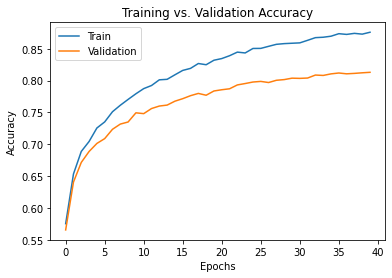

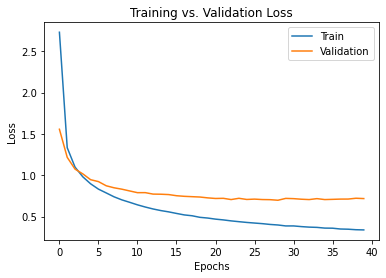

In [0]:
train(model_DP, train_loader, validation_loader, num_epochs=40, learning_rate=0.001)

Definitely a strong 

## With Batch Norm + Denser Architecture

In [0]:
class CNN_BN_Mod(nn.Module):
    def __init__(self):
        super(CNN_BN_Mod, self).__init__()
        self.name = "BN_Mod"
        self.conv1 = nn.Conv2d(1, 16, 3)   # Note: Only one input channel (gray scale)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 120, 3)
        self.conv5 = nn.Conv2d(120, 200, 3)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(120)
        self.bn5 = nn.BatchNorm2d(200)
        self.bn_FC = nn.BatchNorm1d(75)

        self.fc1 = nn.Linear(200 * 3 * 3, 75)
        self.fc2 = nn.Linear(75, 369)

    def forward(self, img):
        x = F.relu(self.bn1(self.conv1(img)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))

        x = x.view(-1, 200 * 3 * 3)
        x = F.relu(self.bn_FC(self.fc1(x)))
        x = self.fc2(x)
        return x

In [0]:
model_mod = CNN_BN_Mod()
use_cuda = True
model_mod.cuda()

CNN_BN_Mod(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 120, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(120, 200, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1800, out_features=75, bias=Tr

In [0]:
model_mod.train()

CNN_BN_Mod(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 120, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(120, 200, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1800, out_features=75, bias=Tr

Training started...
Epoch #0, Training Loss: 1.8316, Validation Loss: 0.8359
Epoch #0, Training Accuracy: 0.7604, Validation Accuracy: 0.7408
Epoch #1, Training Loss: 0.6797, Validation Loss: 0.6546
Epoch #1, Training Accuracy: 0.8145, Validation Accuracy: 0.7825
Epoch #2, Training Loss: 0.5055, Validation Loss: 0.5646
Epoch #2, Training Accuracy: 0.8520, Validation Accuracy: 0.8101
Epoch #3, Training Loss: 0.3933, Validation Loss: 0.5181
Epoch #3, Training Accuracy: 0.8792, Validation Accuracy: 0.8299
Epoch #4, Training Loss: 0.3132, Validation Loss: 0.4917
Epoch #4, Training Accuracy: 0.8979, Validation Accuracy: 0.8425
Epoch #5, Training Loss: 0.2527, Validation Loss: 0.4940
Epoch #5, Training Accuracy: 0.9092, Validation Accuracy: 0.8465
Epoch #6, Training Loss: 0.2109, Validation Loss: 0.4881
Epoch #6, Training Accuracy: 0.9209, Validation Accuracy: 0.8545
Epoch #7, Training Loss: 0.1782, Validation Loss: 0.5102
Epoch #7, Training Accuracy: 0.9253, Validation Accuracy: 0.8563
Epoc

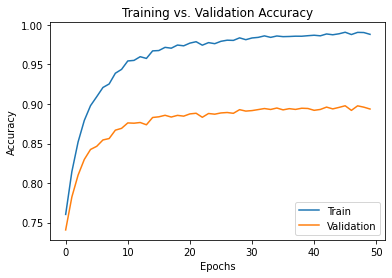

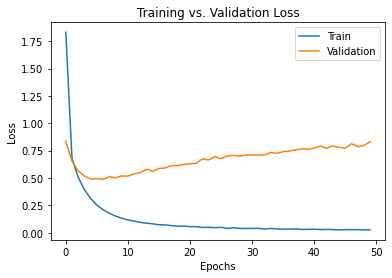

In [0]:
train(model_mod, train_loader, validation_loader, num_epochs=50, learning_rate=0.001)

For the purposes of testing the live demo, let's go ahead and take epoch #48...

In [0]:
name = "BN_Mod"
path = get_model_name(name, batch_size=128, learning_rate=0.001, epoch=48)

model = CNN_BN_Mod()
model.load_state_dict(torch.load(path_test))
model.cuda()
model.eval()

In [0]:
path_test = get_model_name(model_mod.name, batch_size=128, learning_rate=0.001, epoch=48)

In [0]:
model = CNN_BN_Mod() 
# Load in its weights
model.load_state_dict(torch.load(path_test))
# RUN THIS STEP IF USING GPU
model.cuda()
model.eval()

CNN_BN_Mod(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 120, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(120, 200, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1800, out_features=75, bias=Tr

In [0]:
get_accuracy(model, test_loader)

0.8980255516840883

In [0]:
get_accuracy(model, validation_loader)

0.8993999225706543

In [0]:
true_states, pred_states = prepare_full_accuracy(model, validation_loader)

In [0]:
all_accuracy_dict = full_accuracy_totals(true_states, pred_states)

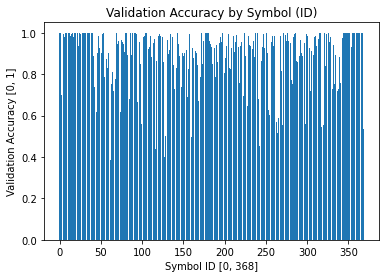

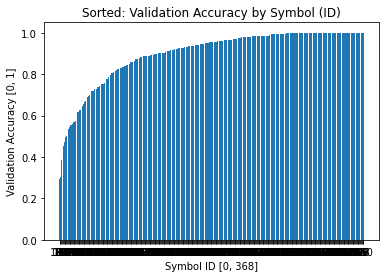

In [0]:
plot_accuracy(all_accuracy_dict)

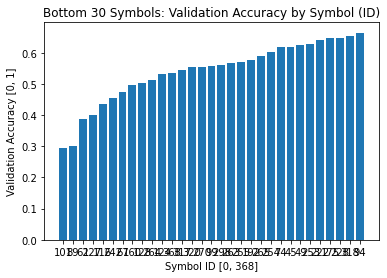

In [0]:
worst = plot_X_accuracy(all_accuracy_dict, 30, "Bottom")

In [0]:
sort_dictionary(all_accuracy_dict)

[(101, (0.295, 41, 139)),
 (89, (0.3015, 41, 136)),
 (62, (0.3867, 58, 150)),
 (127, (0.4, 52, 130)),
 (116, (0.4365, 55, 126)),
 (242, (0.4545, 60, 132)),
 (67, (0.4741, 64, 135)),
 (160, (0.4961, 64, 129)),
 (128, (0.5035, 72, 143)),
 (264, (0.5141, 73, 142)),
 (124, (0.5315, 76, 143)),
 (368, (0.5342, 78, 146)),
 (317, (0.5455, 84, 154)),
 (320, (0.554, 77, 139)),
 (270, (0.5541, 82, 148)),
 (99, (0.5588, 95, 170)),
 (298, (0.56, 84, 150)),
 (263, (0.5674, 80, 141)),
 (255, (0.5704, 77, 135)),
 (192, (0.576, 72, 125)),
 (265, (0.5882, 80, 136)),
 (254, (0.6034, 70, 116)),
 (74, (0.6183, 81, 131)),
 (45, (0.619, 91, 147)),
 (49, (0.626, 82, 131)),
 (253, (0.6268, 89, 142)),
 (222, (0.6418, 86, 134)),
 (175, (0.6462, 84, 130)),
 (228, (0.6474, 112, 173)),
 (318, (0.6547, 91, 139)),
 (94, (0.6644, 99, 149)),
 (168, (0.6691, 93, 139)),
 (85, (0.6788, 93, 137)),
 (241, (0.6788, 93, 137)),
 (155, (0.6912, 94, 136)),
 (223, (0.695, 98, 141)),
 (2, (0.698, 104, 149)),
 (100, (0.7099, 93, 13

In [0]:
matrix = confusion_matrix(true_states, pred_states, normalize='true')

In [0]:
for i in worst:
  get_single_confusion(matrix, i)


This symbol is:  \circ

Confusion analysis:

{'0': 0.0216, 'O': 0.0288, '\\circ': 0.295, '\\circlearrowleft': 0.0072, '\\degree': 0.4101, '\\diamondsuit': 0.0072, '\\fullmoon': 0.0863, '\\lozenge': 0.0072, '\\mathcal{O}': 0.0935, '\\rho': 0.0072, '\\sigma': 0.0072, 'o': 0.0288}

This symbol is:  \bot

Confusion analysis:

{'L': 0.0074, '\\Delta': 0.0074, '\\bot': 0.3015, '\\lfloor': 0.0074, '\\perp': 0.6691, '\\rfloor': 0.0074}

This symbol is:  \Pi

Confusion analysis:

{'J': 0.0067, '\\Gamma': 0.0067, '\\Pi': 0.3867, '\\aleph': 0.0067, '\\dashv': 0.0067, '\\degree': 0.0067, '\\eta': 0.0067, '\\hbar': 0.0067, '\\mathscr{F}': 0.0067, '\\mathscr{H}': 0.0067, '\\pi': 0.2133, '\\pitchfork': 0.0067, '\\prec': 0.0067, '\\prod': 0.2733, '\\sqcap': 0.0133, '\\sqrt{}': 0.0067, '\\tau': 0.0267, 'n': 0.0067}

This symbol is:  \emptyset

Confusion analysis:

{'\\&': 0.0077, '\\O': 0.0923, '\\Phi': 0.0077, '\\circlearrowright': 0.0077, '\\diameter': 0.0308, '\\emptyset': 0.4, '\\gamma': 0.0077, '

### Continued Training

In [0]:
name = "BN_Mod"
path = get_model_name(name, batch_size=128, learning_rate=0.001, epoch=48)

model = CNN_BN_Mod()
model.load_state_dict(torch.load(path))
model.cuda()
model.train()

CNN_BN_Mod(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 120, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(120, 200, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1800, out_features=75, bias=Tr

Training started...
Epoch #0, Training Loss: 0.0271, Validation Loss: 0.8200
Epoch #0, Training Accuracy: 0.9886, Validation Accuracy: 0.8951
Epoch #1, Training Loss: 0.0258, Validation Loss: 0.8131
Epoch #1, Training Accuracy: 0.9916, Validation Accuracy: 0.8990
Epoch #2, Training Loss: 0.0242, Validation Loss: 0.8245
Epoch #2, Training Accuracy: 0.9908, Validation Accuracy: 0.8967
Epoch #3, Training Loss: 0.0264, Validation Loss: 0.8199
Epoch #3, Training Accuracy: 0.9908, Validation Accuracy: 0.8979
Epoch #4, Training Loss: 0.0237, Validation Loss: 0.8373
Epoch #4, Training Accuracy: 0.9905, Validation Accuracy: 0.8968
Epoch #5, Training Loss: 0.0253, Validation Loss: 0.8589
Epoch #5, Training Accuracy: 0.9894, Validation Accuracy: 0.8940
Epoch #6, Training Loss: 0.0233, Validation Loss: 0.8404
Epoch #6, Training Accuracy: 0.9920, Validation Accuracy: 0.9001
Epoch #7, Training Loss: 0.0224, Validation Loss: 0.8596
Epoch #7, Training Accuracy: 0.9912, Validation Accuracy: 0.8963
Epoc

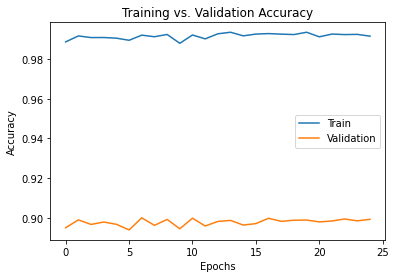

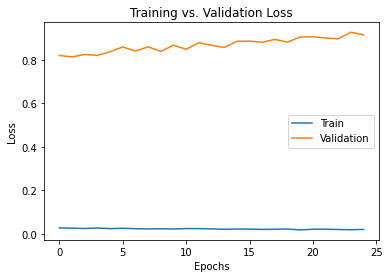

In [0]:
use_cuda = True
train(model, train_loader, validation_loader, num_epochs=25, learning_rate=0.001)

## Deep Batch Norm Model With Dropped Classes

In [0]:
class CNN_BN_Mod(nn.Module):
    def __init__(self):
        super(CNN_BN_Mod, self).__init__()
        self.name = "BN_Mod"
        self.conv1 = nn.Conv2d(1, 16, 3)   # Note: Only one input channel (gray scale)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 120, 3)
        self.conv5 = nn.Conv2d(120, 200, 3)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(120)
        self.bn5 = nn.BatchNorm2d(200)
        self.bn_FC = nn.BatchNorm1d(80)

        self.fc1 = nn.Linear(200 * 3 * 3, 80)
        self.fc2 = nn.Linear(80, 369)

    def forward(self, img):
        x = F.relu(self.bn1(self.conv1(img)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))

        x = x.view(-1, 200 * 3 * 3)
        x = F.relu(self.bn_FC(self.fc1(x)))
        x = self.fc2(x)
        return x

In [0]:
model_drop = CNN_BN_Mod()
use_cuda = True
model_drop.cuda()

CNN_BN_Mod(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 120, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(120, 200, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1800, out_features=80, bias=Tr

In [0]:
model_drop.train()

CNN_BN_Mod(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 120, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(120, 200, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1800, out_features=80, bias=Tr

In [0]:
train(model_drop, train_loader, validation_loader, num_epochs=50, learning_rate=0.001)

Training started...
Epoch #0, Training Loss: 1.7710, Validation Loss: 0.7532
Epoch #0, Training Accuracy: 0.7983, Validation Accuracy: 0.7810
Epoch #1, Training Loss: 0.6082, Validation Loss: 0.5629
Epoch #1, Training Accuracy: 0.8527, Validation Accuracy: 0.8259
Epoch #2, Training Loss: 0.4362, Validation Loss: 0.4932
Epoch #2, Training Accuracy: 0.8829, Validation Accuracy: 0.8464
Epoch #3, Training Loss: 0.3283, Validation Loss: 0.4487
Epoch #3, Training Accuracy: 0.9051, Validation Accuracy: 0.8615
Epoch #4, Training Loss: 0.2538, Validation Loss: 0.4290
Epoch #4, Training Accuracy: 0.9207, Validation Accuracy: 0.8711
Epoch #5, Training Loss: 0.1979, Validation Loss: 0.4140
Epoch #5, Training Accuracy: 0.9336, Validation Accuracy: 0.8802
Epoch #6, Training Loss: 0.1584, Validation Loss: 0.4074
Epoch #6, Training Accuracy: 0.9465, Validation Accuracy: 0.8884
Epoch #7, Training Loss: 0.1328, Validation Loss: 0.4086
Epoch #7, Training Accuracy: 0.9547, Validation Accuracy: 0.8926
Epoc

Resuming training below...note that the above crashed because you disconnected from the internet

Training started...
Epoch #0, Training Loss: 1.7428, Validation Loss: 0.7446
Epoch #0, Training Accuracy: 0.8001, Validation Accuracy: 0.7851
Epoch #1, Training Loss: 0.5981, Validation Loss: 0.5717
Epoch #1, Training Accuracy: 0.8529, Validation Accuracy: 0.8242
Epoch #2, Training Loss: 0.4295, Validation Loss: 0.4965
Epoch #2, Training Accuracy: 0.8817, Validation Accuracy: 0.8456
Epoch #3, Training Loss: 0.3239, Validation Loss: 0.4505
Epoch #3, Training Accuracy: 0.9053, Validation Accuracy: 0.8605
Epoch #4, Training Loss: 0.2503, Validation Loss: 0.4244
Epoch #4, Training Accuracy: 0.9213, Validation Accuracy: 0.8719
Epoch #5, Training Loss: 0.1956, Validation Loss: 0.4109
Epoch #5, Training Accuracy: 0.9331, Validation Accuracy: 0.8795
Epoch #6, Training Loss: 0.1584, Validation Loss: 0.4130
Epoch #6, Training Accuracy: 0.9407, Validation Accuracy: 0.8849
Epoch #7, Training Loss: 0.1314, Validation Loss: 0.4130
Epoch #7, Training Accuracy: 0.9505, Validation Accuracy: 0.8885
Epoc

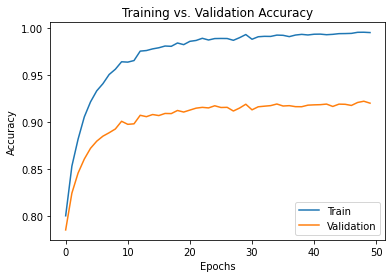

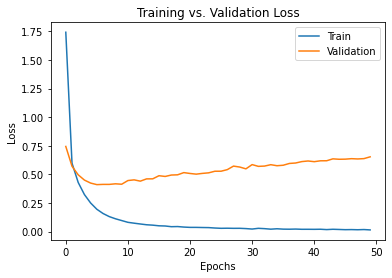

In [0]:
train(model_drop, train_loader, validation_loader, num_epochs=50, learning_rate=0.001)

Okay...so epoch #48 looks good, but it shold be noted that there is an extremely modest but still noticeable growth in validation accuracy with further training.

In [0]:
path_test = get_model_name(model_drop.name, batch_size=128, learning_rate=0.001, epoch=48)

In [0]:
model = CNN_BN_Mod() 
# Load in its weights
model.load_state_dict(torch.load(path_test))
# RUN THIS STEP IF USING GPU
model.cuda()
model.eval()

CNN_BN_Mod(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 120, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(120, 200, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_FC): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1800, out_features=80, bias=Tr

In [0]:
get_accuracy(model, test_loader)

0.922495894909688

In [0]:
true_states, pred_states = prepare_full_accuracy(model, test_loader)

In [0]:
all_accuracy_dict = full_accuracy_totals(true_states, pred_states)

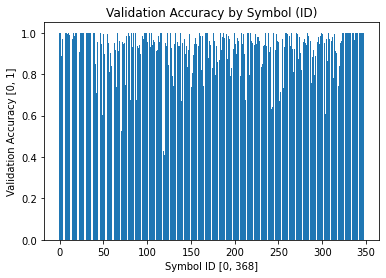

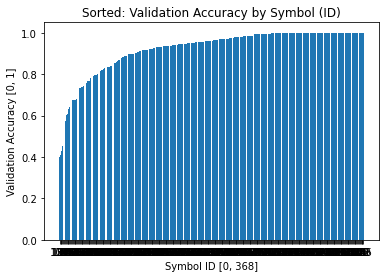

In [0]:
plot_accuracy(all_accuracy_dict)

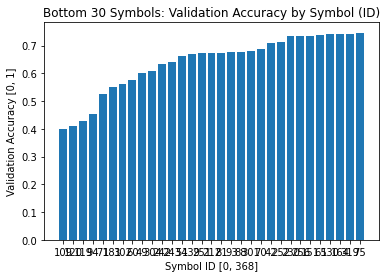

In [0]:
worst = plot_X_accuracy(all_accuracy_dict, 30, "Bottom")

In [0]:
matrix = confusion_matrix(true_states, pred_states, normalize='true')

In [0]:
for i in worst:
  get_single_confusion(matrix, i)


This symbol is:  \degree

Confusion analysis:

{'0': 0.0327, 'D': 0.0065, 'O': 0.0327, '\\O': 0.0065, '\\Omega': 0.0065, '\\cap': 0.0065, '\\celsius': 0.0131, '\\circ': 0.2876, '\\circlearrowleft': 0.0065, '\\circlearrowright': 0.0065, '\\degree': 0.3987, '\\diamondsuit': 0.0065, '\\ell': 0.0065, '\\emptyset': 0.0065, '\\fullmoon': 0.0392, '\\heartsuit': 0.0065, '\\lozenge': 0.0131, '\\mathcal{D}': 0.0065, '\\mathcal{N}': 0.0065, '\\mathcal{O}': 0.0588, '\\mathfrak{S}': 0.0065, '\\partial': 0.0065, '\\sharp': 0.0065, '\\sigma': 0.0065, '\\subset': 0.0065, '\\triangledown': 0.0065, 'n': 0.0065}

This symbol is:  \epsilon

Confusion analysis:

{'E': 0.0122, '\\Delta': 0.0122, '\\Leftrightarrow': 0.0061, '\\Sigma': 0.0122, '\\celsius': 0.0061, '\\delta': 0.0061, '\\ell': 0.0061, '\\epsilon': 0.4085, '\\in': 0.2622, '\\leq': 0.0122, '\\mathcal{E}': 0.0915, '\\mathds{E}': 0.0061, '\\varepsilon': 0.1585}

This symbol is:  \emptyset

Confusion analysis:

{'\\$': 0.0067, '\\&': 0.0067, '\\O':

In [0]:
sort_dictionary(all_accuracy_dict)

[(109, (0.3987, 61, 153, '\\degree')),
 (120, (0.4085, 67, 164, '\\epsilon')),
 (119, (0.4267, 64, 150, '\\emptyset')),
 (94, (0.4545, 65, 143, '\\circ')),
 (71, (0.5248, 74, 141, '\\alpha')),
 (181, (0.55, 77, 140, '\\mathcal{O}')),
 (302, (0.5608, 83, 148, '\\varepsilon')),
 (60, (0.5746, 77, 134, '\\Pi')),
 (49, (0.6014, 83, 138, '\\Delta')),
 (304, (0.6093, 92, 151, '\\varnothing')),
 (242, (0.6336, 83, 131, '\\phi')),
 (243, (0.6397, 87, 136, '\\pi')),
 (54, (0.6641, 87, 131, '\\Lambda')),
 (139, (0.6714, 94, 140, '\\in')),
 (251, (0.6718, 88, 131, '\\propto')),
 (212, (0.6739, 93, 138, '\\models')),
 (81, (0.6742, 89, 132, '\\beta')),
 (93, (0.6757, 100, 148, '\\chi')),
 (88, (0.6763, 94, 139, '\\bullet')),
 (301, (0.6788, 93, 137, '\\vDash')),
 (70, (0.6884, 95, 138, '\\aleph')),
 (42, (0.7109, 91, 128, '\\#')),
 (252, (0.7143, 95, 133, '\\psi')),
 (230, (0.7338, 102, 139, '\\o')),
 (256, (0.7353, 100, 136, '\\rho')),
 (151, (0.7361, 106, 144, '\\leq')),
 (65, (0.7368, 112, 152,

# Final ResNet Based Models

## ResNet Architecture Implementation

In [0]:
# Below code for this ResNet implementation is from the code provided in the following tutorial:
# https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278

In [0]:
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

In [0]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        

In [0]:
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)      
conv = conv3x3(in_channels=32, out_channels=64)
print(conv)
del conv

Conv2dAuto(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [0]:
def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [0]:
ResidualBlock(32, 64)

ResidualBlock(
  (blocks): Identity()
  (activate): ReLU(inplace=True)
  (shortcut): Identity()
)

In [0]:

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

In [0]:
ResNetResidualBlock(32, 64)

ResNetResidualBlock(
  (blocks): Identity()
  (activate): ReLU(inplace=True)
  (shortcut): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [0]:
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels))

In [0]:
class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
    

In [0]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation_func(self.activation),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

In [0]:
class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [0]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation='relu', block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation_func(activation),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,*args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [0]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        #### NEW LINE ####
        #self.drop = nn.Dropout(p=0.5)
        #self.hidden = nn.Linear(in_features, 200)
        #self.decoder = nn.Linear(200, n_classes)

        #self.bn_FC = nn.BatchNorm1d(200)

        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        #x = self.drop(F.relu(self.bn_FC(self.hidden(x))))
        #x = F.relu(self.bn_FC(self.hidden(x)))
        x = self.decoder(x)
        return x

In [0]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.name = "ResNet"
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
def resnet18(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[2, 2, 2, 2], *args, **kwargs)

In [0]:
def resnet34(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[3, 4, 6, 3], *args, **kwargs)

## ResNet-18 Initial Run

In [0]:
resnet_model = resnet18(1, 369)

In [0]:
use_cuda = True
resnet_model.cuda()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [0]:
resnet_model.train()

Training started...
Epoch #0, Training Loss: 1.1990, Validation Loss: 0.7150
Epoch #0, Training Accuracy: 0.7945, Validation Accuracy: 0.7767
Epoch #1, Training Loss: 0.5940, Validation Loss: 0.5706
Epoch #1, Training Accuracy: 0.8420, Validation Accuracy: 0.8162
Epoch #2, Training Loss: 0.4492, Validation Loss: 0.5256
Epoch #2, Training Accuracy: 0.8627, Validation Accuracy: 0.8316
Epoch #3, Training Loss: 0.3553, Validation Loss: 0.4883
Epoch #3, Training Accuracy: 0.8832, Validation Accuracy: 0.8467
Epoch #4, Training Loss: 0.2898, Validation Loss: 0.4500
Epoch #4, Training Accuracy: 0.9036, Validation Accuracy: 0.8625
Epoch #5, Training Loss: 0.2373, Validation Loss: 0.4378
Epoch #5, Training Accuracy: 0.9171, Validation Accuracy: 0.8735
Epoch #6, Training Loss: 0.1943, Validation Loss: 0.4348
Epoch #6, Training Accuracy: 0.9270, Validation Accuracy: 0.8795
Epoch #7, Training Loss: 0.1663, Validation Loss: 0.4325
Epoch #7, Training Accuracy: 0.9371, Validation Accuracy: 0.8860
Epoc

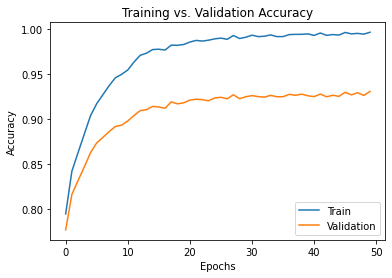

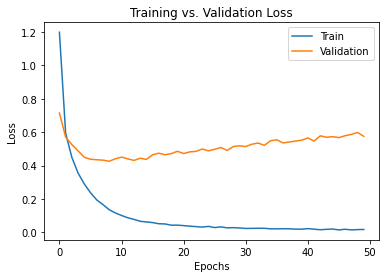

In [0]:
train(resnet_model, train_loader, validation_loader, num_epochs=50, learning_rate=0.001)

Training started...
Epoch #0, Training Loss: 0.0143, Validation Loss: 0.6132
Epoch #0, Training Accuracy: 0.9951, Validation Accuracy: 0.9286
Epoch #1, Training Loss: 0.0168, Validation Loss: 0.6188
Epoch #1, Training Accuracy: 0.9949, Validation Accuracy: 0.9280
Epoch #2, Training Loss: 0.0141, Validation Loss: 0.6184
Epoch #2, Training Accuracy: 0.9946, Validation Accuracy: 0.9280
Epoch #3, Training Loss: 0.0155, Validation Loss: 0.6199
Epoch #3, Training Accuracy: 0.9962, Validation Accuracy: 0.9272
Epoch #4, Training Loss: 0.0135, Validation Loss: 0.6231
Epoch #4, Training Accuracy: 0.9955, Validation Accuracy: 0.9287
Epoch #5, Training Loss: 0.0141, Validation Loss: 0.6123
Epoch #5, Training Accuracy: 0.9959, Validation Accuracy: 0.9297
Epoch #6, Training Loss: 0.0137, Validation Loss: 0.6226
Epoch #6, Training Accuracy: 0.9958, Validation Accuracy: 0.9274
Epoch #7, Training Loss: 0.0145, Validation Loss: 0.6209
Epoch #7, Training Accuracy: 0.9964, Validation Accuracy: 0.9284
Epoc

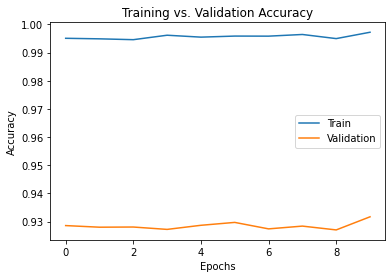

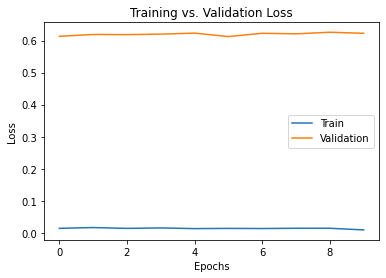

In [0]:
# There was a slight dip in loss there at the end...
# Let's train just 10 epochs more to see if there is more to go down
train(resnet_model, train_loader, validation_loader, num_epochs=10, learning_rate=0.001)

### Results

In [0]:
# Let's take a few of these and peak at the test set
# Pull out epoch #36 from before
path_test = get_model_name(resnet_model.name, batch_size=128, learning_rate=0.001, epoch=36)

In [0]:
model = resnet18(1, 369)
# Load in its weights
model.load_state_dict(torch.load(path_test))
# RUN THIS STEP IF USING GPU
model.cuda()
model.eval()

In [0]:
get_accuracy(model, test_loader)

0.9293103448275862

In [0]:
true_states, pred_states = prepare_full_accuracy(model, test_loader)

In [0]:
all_accuracy_dict = full_accuracy_totals(true_states, pred_states)

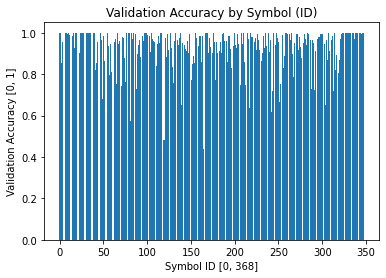

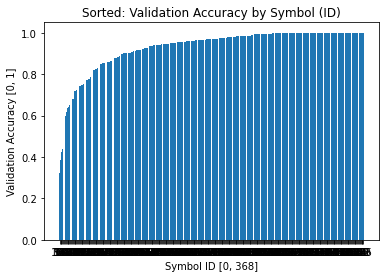

In [0]:
plot_accuracy(all_accuracy_dict)

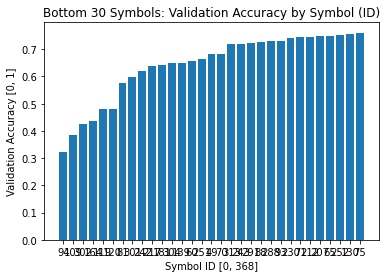

In [0]:
worst = plot_X_accuracy(all_accuracy_dict, 30, "Bottom")

In [0]:
matrix = confusion_matrix(true_states, pred_states, normalize='true')

In [0]:
for i in worst:
  get_single_confusion(matrix, i)


This symbol is:  \circ

Confusion analysis:

{'0': 0.021, 'O': 0.021, '\\Delta': 0.007, '\\circ': 0.3217, '\\circlearrowright': 0.007, '\\cup': 0.007, '\\degree': 0.2797, '\\fullmoon': 0.2378, '\\mars': 0.007, '\\mathcal{O}': 0.049, '\\mathscr{S}': 0.007, '\\square': 0.007, '\\zeta': 0.007, 'o': 0.021}

This symbol is:  \degree

Confusion analysis:

{'0': 0.0196, 'O': 0.0392, '\\bullet': 0.0131, '\\celsius': 0.0196, '\\circ': 0.3137, '\\circlearrowleft': 0.0065, '\\clubsuit': 0.0065, '\\degree': 0.3856, '\\fullmoon': 0.0719, '\\heartsuit': 0.0065, '\\lhd': 0.0065, '\\mathcal{D}': 0.0131, '\\mathcal{O}': 0.0327, '\\omega': 0.0065, '\\partial': 0.0065, '\\phi': 0.0065, '\\rho': 0.0065, '\\square': 0.0065, '\\ss': 0.0065, '\\subset': 0.0065, '\\triangleright': 0.0065, 'n': 0.0065, 'o': 0.0065}

This symbol is:  \varepsilon

Confusion analysis:

{'\\Sigma': 0.0135, '\\ae': 0.0068, '\\epsilon': 0.1284, '\\leqslant': 0.0068, '\\mathcal{E}': 0.3851, '\\mathds{E}': 0.0068, '\\mathscr{E}': 0.0

In [0]:
sort_dictionary(all_accuracy_dict)

[(94, (0.3217, 46, 143, '\\circ')),
 (109, (0.3856, 59, 153, '\\degree')),
 (302, (0.4257, 63, 148, '\\varepsilon')),
 (164, (0.4375, 56, 128, '\\mathbb{1}')),
 (119, (0.48, 72, 150, '\\emptyset')),
 (120, (0.4817, 79, 164, '\\epsilon')),
 (81, (0.5758, 76, 132, '\\beta')),
 (301, (0.5985, 82, 137, '\\vDash')),
 (242, (0.6183, 81, 131, '\\phi')),
 (217, (0.6375, 102, 160, '\\nabla')),
 (181, (0.6429, 90, 140, '\\mathcal{O}')),
 (304, (0.649, 98, 151, '\\varnothing')),
 (139, (0.65, 91, 140, '\\in')),
 (60, (0.6567, 88, 134, '\\Pi')),
 (251, (0.6641, 87, 131, '\\propto')),
 (49, (0.6812, 94, 138, '\\Delta')),
 (70, (0.6812, 94, 138, '\\aleph')),
 (313, (0.7183, 102, 142, '\\vee')),
 (243, (0.7206, 98, 136, '\\pi')),
 (291, (0.7226, 99, 137, '\\triangle')),
 (88, (0.7266, 101, 139, '\\bullet')),
 (288, (0.729, 113, 155, '\\theta')),
 (93, (0.7297, 108, 148, '\\chi')),
 (230, (0.741, 103, 139, '\\o')),
 (71, (0.7447, 105, 141, '\\alpha')),
 (212, (0.7464, 103, 138, '\\models')),
 (207, (0

## ResNet-18 With Hidden Layers

In [0]:
resnet_model_HU = resnet18(1, 369)

In [0]:
use_cuda = True
resnet_model_HU.cuda()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [0]:
resnet_model_HU.train()

In [0]:
train(resnet_model_HU, train_loader, validation_loader, num_epochs=55, learning_rate=0.001)

Training started...
Epoch #0, Training Loss: 1.3825, Validation Loss: 0.7067
Epoch #0, Training Accuracy: 0.7927, Validation Accuracy: 0.7775
Epoch #1, Training Loss: 0.5846, Validation Loss: 0.5686
Epoch #1, Training Accuracy: 0.8379, Validation Accuracy: 0.8150


KeyboardInterrupt: ignored

Training time is FAR too slow with the increase in parameters

## Resnet-34 Testing

In [0]:
resnet_model34 = resnet34(1, 369)

In [0]:
use_cuda = True
resnet_model34.cuda()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [0]:
resnet_model34.train()

In [0]:
train(resnet_model34, train_loader, validation_loader, num_epochs=50, learning_rate=0.001)

Training started...
Epoch #0, Training Loss: 1.3568, Validation Loss: 0.7764
Epoch #0, Training Accuracy: 0.7748, Validation Accuracy: 0.7598
Epoch #1, Training Loss: 0.6542, Validation Loss: 0.6340
Epoch #1, Training Accuracy: 0.8207, Validation Accuracy: 0.7975
Epoch #2, Training Loss: 0.5050, Validation Loss: 0.5434
Epoch #2, Training Accuracy: 0.8518, Validation Accuracy: 0.8260
Epoch #3, Training Loss: 0.4117, Validation Loss: 0.5208
Epoch #3, Training Accuracy: 0.8662, Validation Accuracy: 0.8356
Epoch #4, Training Loss: 0.3454, Validation Loss: 0.4986
Epoch #4, Training Accuracy: 0.8799, Validation Accuracy: 0.8423
Epoch #5, Training Loss: 0.2882, Validation Loss: 0.4628
Epoch #5, Training Accuracy: 0.8977, Validation Accuracy: 0.8581
Epoch #6, Training Loss: 0.2425, Validation Loss: 0.4291
Epoch #6, Training Accuracy: 0.9158, Validation Accuracy: 0.8725
Epoch #7, Training Loss: 0.2039, Validation Loss: 0.4228
Epoch #7, Training Accuracy: 0.9248, Validation Accuracy: 0.8754
Epoc

KeyboardInterrupt: ignored

## ResNet-18 With Dropout and Hidden Layers

In [0]:
resnet18_new = resnet18(1, 369)

In [0]:
use_cuda = True
resnet18_new.cuda()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [0]:
resnet18_new.train()

In [0]:
train(resnet18_new, train_loader, validation_loader, num_epochs=65, learning_rate=0.001)

Training started...
Epoch #0, Training Loss: 1.6620, Validation Loss: 0.8942
Epoch #0, Training Accuracy: 0.7411, Validation Accuracy: 0.7260
Epoch #1, Training Loss: 0.7508, Validation Loss: 0.6878
Epoch #1, Training Accuracy: 0.8003, Validation Accuracy: 0.7820
Epoch #2, Training Loss: 0.5960, Validation Loss: 0.6126
Epoch #2, Training Accuracy: 0.8291, Validation Accuracy: 0.8053
Epoch #3, Training Loss: 0.4935, Validation Loss: 0.5534


KeyboardInterrupt: ignored

^ STUPIDLY long run time...

## ResNet-18: ***OFFICIAL RUN*** (With Dropped Classes)

In [0]:
resnet_model = resnet18(1, 348)

In [0]:
use_cuda = True
resnet_model.cuda()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [0]:
resnet_model.train()

Training started...
Epoch #0, Training Loss: 1.1864, Validation Loss: 0.7256
Epoch #0, Training Accuracy: 0.7891, Validation Accuracy: 0.7754
Epoch #1, Training Loss: 0.5956, Validation Loss: 0.5785
Epoch #1, Training Accuracy: 0.8384, Validation Accuracy: 0.8148
Epoch #2, Training Loss: 0.4512, Validation Loss: 0.5238
Epoch #2, Training Accuracy: 0.8623, Validation Accuracy: 0.8331
Epoch #3, Training Loss: 0.3605, Validation Loss: 0.4750
Epoch #3, Training Accuracy: 0.8874, Validation Accuracy: 0.8492
Epoch #4, Training Loss: 0.2909, Validation Loss: 0.4661
Epoch #4, Training Accuracy: 0.8992, Validation Accuracy: 0.8578
Epoch #5, Training Loss: 0.2360, Validation Loss: 0.4284
Epoch #5, Training Accuracy: 0.9189, Validation Accuracy: 0.8737
Epoch #6, Training Loss: 0.1946, Validation Loss: 0.4387
Epoch #6, Training Accuracy: 0.9264, Validation Accuracy: 0.8763
Epoch #7, Training Loss: 0.1672, Validation Loss: 0.4146
Epoch #7, Training Accuracy: 0.9408, Validation Accuracy: 0.8888
Epoc

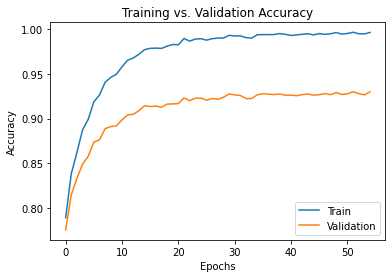

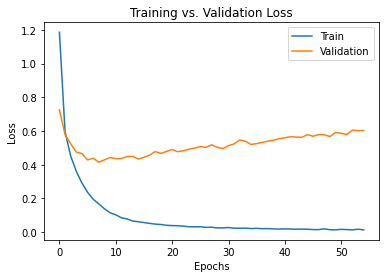

In [0]:
train(resnet_model, train_loader, validation_loader, num_epochs=55, learning_rate=0.001)

### ***OFFICIAL RESULTS***

In [0]:
# 29 --> 92.76 --> 0.496
# 35 --> 92.78 --> 0.5253
# 51 --> 93.01 --> 0.5794

path_test = get_model_name(resnet_model.name, batch_size=128, learning_rate=0.001, epoch=29)

In [0]:
model = resnet18(1, 348)
# Load in its weights
model.load_state_dict(torch.load(path_test))

<All keys matched successfully>

In [0]:
model.cuda()

In [0]:
model.eval()

In [0]:
get_accuracy(model, test_loader)

0.9284893267651888

In [0]:
true_states, pred_states = prepare_full_accuracy(model, test_loader)

In [0]:
all_accuracy_dict = full_accuracy_totals(true_states, pred_states)

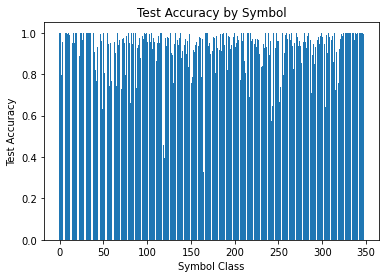

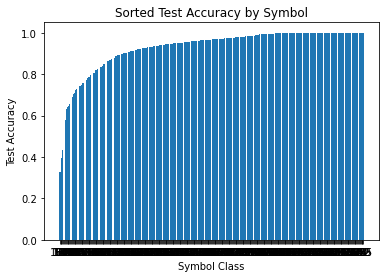

In [0]:
plot_accuracy(all_accuracy_dict)

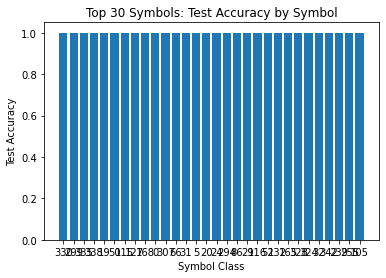

In [0]:
best = plot_X_accuracy(all_accuracy_dict, 30, "Top")

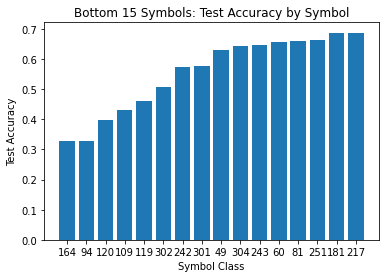

In [0]:
worst = plot_X_accuracy(all_accuracy_dict, 15, "Bottom")

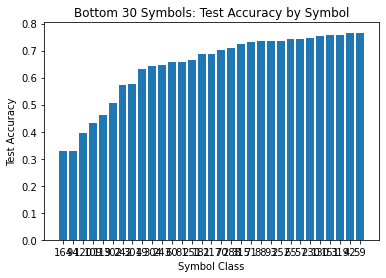

In [0]:
worst = plot_X_accuracy(all_accuracy_dict, 30, "Bottom") 

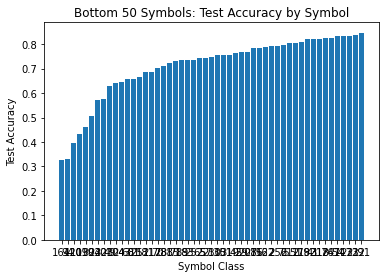

In [0]:
worst = plot_X_accuracy(all_accuracy_dict, 50, "Bottom") 

In [0]:
matrix = confusion_matrix(true_states, pred_states, normalize='true')

In [0]:
for i in worst:
  get_single_confusion(matrix, i)


This symbol is:  \mathbb{1}

Confusion analysis:

{'\\mathbb{1}': 0.3281, '\\mathcal{R}': 0.0078, '\\mathds{1}': 0.6328, '\\mathds{R}': 0.0078, '\\phi': 0.0156, '\\varoiint': 0.0078}

This symbol is:  \circ

Confusion analysis:

{'0': 0.014, 'O': 0.014, '\\circ': 0.3287, '\\circlearrowleft': 0.021, '\\circlearrowright': 0.007, '\\degree': 0.3077, '\\diamond': 0.007, '\\fullmoon': 0.0839, '\\mathcal{O}': 0.1329, '\\nearrow': 0.007, '\\sigma': 0.007, '\\square': 0.007, '\\subsetneq': 0.007, '\\triangledown': 0.007, 'o': 0.049}

This symbol is:  \epsilon

Confusion analysis:

{'E': 0.0122, '\\delta': 0.0061, '\\epsilon': 0.3963, '\\in': 0.2805, '\\leq': 0.0122, '\\mathcal{E}': 0.0854, '\\mathds{E}': 0.0061, '\\mathfrak{S}': 0.0061, '\\pounds': 0.0061, '\\sigma': 0.0061, '\\varepsilon': 0.1768, '\\{': 0.0061}

This symbol is:  \degree

Confusion analysis:

{'0': 0.0196, 'O': 0.0065, '\\Delta': 0.0065, '\\cap': 0.0065, '\\cdot': 0.0065, '\\celsius': 0.0196, '\\circ': 0.2418, '\\circlearrow

In [0]:
sort_dictionary(all_accuracy_dict)

[(164, (0.3281, 42, 128, '\\mathbb{1}')),
 (94, (0.3287, 47, 143, '\\circ')),
 (120, (0.3963, 65, 164, '\\epsilon')),
 (109, (0.4314, 66, 153, '\\degree')),
 (119, (0.46, 69, 150, '\\emptyset')),
 (302, (0.5068, 75, 148, '\\varepsilon')),
 (242, (0.5725, 75, 131, '\\phi')),
 (301, (0.5766, 79, 137, '\\vDash')),
 (49, (0.6304, 87, 138, '\\Delta')),
 (304, (0.6424, 97, 151, '\\varnothing')),
 (243, (0.6471, 88, 136, '\\pi')),
 (60, (0.6567, 88, 134, '\\Pi')),
 (81, (0.6591, 87, 132, '\\beta')),
 (251, (0.6641, 87, 131, '\\propto')),
 (181, (0.6857, 96, 140, '\\mathcal{O}')),
 (217, (0.6875, 110, 160, '\\nabla')),
 (70, (0.7029, 97, 138, '\\aleph')),
 (288, (0.7097, 110, 155, '\\theta')),
 (315, (0.7241, 84, 116, '\\wedge')),
 (71, (0.7305, 103, 141, '\\alpha')),
 (88, (0.7338, 102, 139, '\\bullet')),
 (93, (0.7365, 109, 148, '\\chi')),
 (252, (0.7368, 98, 133, '\\psi')),
 (65, (0.7434, 113, 152, '\\Theta')),
 (57, (0.7445, 102, 137, '\\O')),
 (230, (0.7482, 104, 139, '\\o')),
 (130, (0.7

In [0]:
all_accuracy_dict = full_accuracy_totals(true_states, pred_states)

In [0]:
sort_dictionary(all_accuracy_dict)

[(0, ('+', 1.0, 147, 147)),
 (1, ('-', 1.0, 135, 135)),
 (2, ('/', 0.7939, 104, 131)),
 (3, ('0', 0.9531, 122, 128)),
 (4, ('1', 0.9608, 147, 153)),
 (5, ('2', 1.0, 150, 150)),
 (6, ('3', 0.9789, 139, 142)),
 (7, ('4', 1.0, 136, 136)),
 (8, ('5', 1.0, 142, 142)),
 (9, ('6', 0.9933, 149, 150)),
 (10, ('7', 1.0, 119, 119)),
 (11, ('8', 0.9878, 162, 164)),
 (12, ('9', 1.0, 117, 117)),
 (13, ('<', 0.9927, 136, 137)),
 (14, ('>', 1.0, 134, 134)),
 (15, ('A', 0.951, 136, 143)),
 (16, ('B', 1.0, 136, 136)),
 (17, ('C', 0.9527, 141, 148)),
 (18, ('D', 1.0, 132, 132)),
 (19, ('E', 1.0, 146, 146)),
 (20, ('F', 1.0, 150, 150)),
 (21, ('G', 0.965, 138, 143)),
 (22, ('H', 1.0, 132, 132)),
 (23, ('I', 0.8864, 117, 132)),
 (24, ('J', 1.0, 150, 150)),
 (25, ('K', 1.0, 142, 142)),
 (26, ('L', 0.9645, 163, 169)),
 (27, ('M', 1.0, 144, 144)),
 (28, ('N', 1.0, 127, 127)),
 (29, ('O', 1.0, 152, 152)),
 (30, ('P', 1.0, 144, 144)),
 (31, ('Q', 1.0, 149, 149)),
 (32, ('R', 1.0, 159, 159)),
 (33, ('S', 1.0, 13

# Further Experimentation

## ResNet-18 Re-Run

In [0]:
resnet_model = resnet18(1, 348)

In [0]:
use_cuda = True
resnet_model.cuda()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [0]:
resnet_model.train()

Training started...
Epoch #0, Training Loss: 1.2139, Validation Loss: 0.7163
Epoch #0, Training Accuracy: 0.7925, Validation Accuracy: 0.7748
Epoch #1, Training Loss: 0.5979, Validation Loss: 0.5666
Epoch #1, Training Accuracy: 0.8424, Validation Accuracy: 0.8198
Epoch #2, Training Loss: 0.4506, Validation Loss: 0.5155
Epoch #2, Training Accuracy: 0.8646, Validation Accuracy: 0.8354
Epoch #3, Training Loss: 0.3603, Validation Loss: 0.4862
Epoch #3, Training Accuracy: 0.8829, Validation Accuracy: 0.8465
Epoch #4, Training Loss: 0.2960, Validation Loss: 0.4540
Epoch #4, Training Accuracy: 0.8991, Validation Accuracy: 0.8578
Epoch #5, Training Loss: 0.2423, Validation Loss: 0.4418
Epoch #5, Training Accuracy: 0.9130, Validation Accuracy: 0.8695
Epoch #6, Training Loss: 0.1972, Validation Loss: 0.4248
Epoch #6, Training Accuracy: 0.9277, Validation Accuracy: 0.8781
Epoch #7, Training Loss: 0.1671, Validation Loss: 0.4173
Epoch #7, Training Accuracy: 0.9404, Validation Accuracy: 0.8886
Epoc

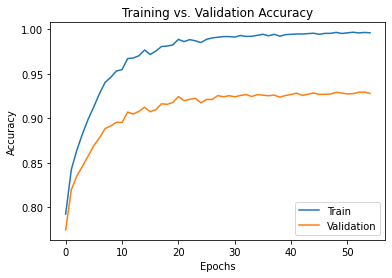

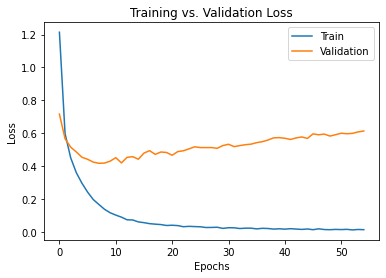

In [0]:
train(resnet_model, train_loader, validation_loader, num_epochs=55, learning_rate=0.001)

### Results

In [0]:
path_test = get_model_name(resnet_model.name, batch_size=128, learning_rate=0.001, epoch=20)

In [0]:
model = resnet18(1, 348)
# Load in its weights
model.load_state_dict(torch.load(path_test))

<All keys matched successfully>

In [0]:
model.cuda()

In [0]:
model.eval()

In [0]:
get_accuracy(model, validation_loader)

0.9259646962233169

In [0]:
get_accuracy(model, test_loader)

0.9277298850574712

In [0]:
true_states, pred_states = prepare_full_accuracy(model, test_loader)

In [0]:
all_accuracy_dict = full_accuracy_totals(true_states, pred_states)

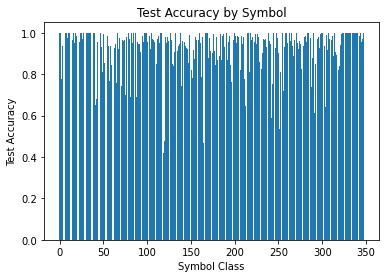

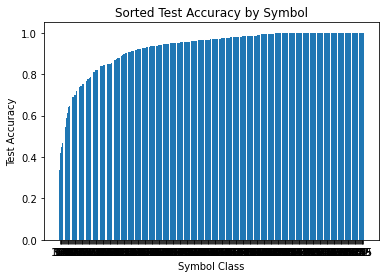

In [0]:
plot_accuracy(all_accuracy_dict, 0.9277298850574712)

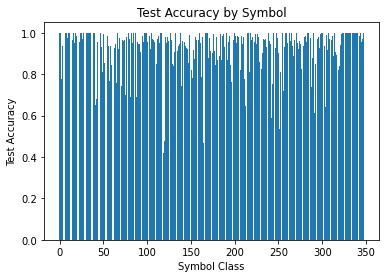

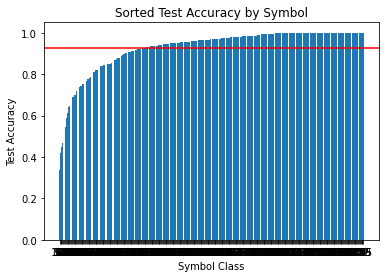

In [0]:
plot_accuracy(all_accuracy_dict, 0.9277298850574712)

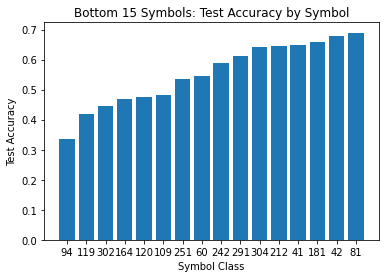

In [0]:
worst = plot_X_accuracy(all_accuracy_dict, 15, "Bottom")

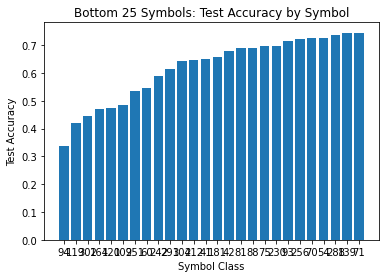

In [0]:
worst = plot_X_accuracy(all_accuracy_dict, 25, "Bottom")

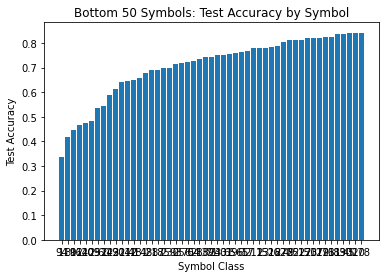

In [0]:
worst = plot_X_accuracy(all_accuracy_dict, 50, "Bottom")

In [0]:
matrix = confusion_matrix(true_states, pred_states, normalize='true')

In [0]:
for i in worst:
  get_single_confusion(matrix, i)


This symbol is:  \circ

Confusion analysis:

{'0': 0.007, 'D': 0.007, 'O': 0.014, '\\circ': 0.3357, '\\circlearrowleft': 0.007, '\\degree': 0.3077, '\\diamond': 0.014, '\\fullmoon': 0.1888, '\\mathcal{O}': 0.042, '\\mathcal{S}': 0.007, '\\nearrow': 0.007, '\\sigma': 0.007, '\\square': 0.007, '\\triangledown': 0.007, '\\triangleleft': 0.007, 'o': 0.035}

This symbol is:  \emptyset

Confusion analysis:

{'\\%': 0.0067, '\\&': 0.0067, '\\O': 0.08, '\\Phi': 0.0067, '\\alpha': 0.0067, '\\degree': 0.0067, '\\diameter': 0.08, '\\diamond': 0.0067, '\\diamondsuit': 0.0067, '\\emptyset': 0.42, '\\kappa': 0.0067, '\\mathcal{P}': 0.0067, '\\mathds{Q}': 0.0067, '\\o': 0.08, '\\oint': 0.0133, '\\phi': 0.0867, '\\theta': 0.0067, '\\varnothing': 0.1667}

This symbol is:  \varepsilon

Confusion analysis:

{'\\Sigma': 0.0068, '\\epsilon': 0.0541, '\\mathcal{E}': 0.4459, '\\mathfrak{S}': 0.0068, '\\mathscr{E}': 0.027, '\\mathsection': 0.0068, '\\varepsilon': 0.4459, '\\{': 0.0068}

This symbol is:  \mat

In [0]:
sort_dictionary(all_accuracy_dict)

[(94, (0.3357, 48, 143, '\\circ')),
 (119, (0.42, 63, 150, '\\emptyset')),
 (302, (0.4459, 66, 148, '\\varepsilon')),
 (164, (0.4688, 60, 128, '\\mathbb{1}')),
 (120, (0.4756, 78, 164, '\\epsilon')),
 (109, (0.4837, 74, 153, '\\degree')),
 (251, (0.5344, 70, 131, '\\propto')),
 (60, (0.5448, 73, 134, '\\Pi')),
 (242, (0.5878, 77, 131, '\\phi')),
 (291, (0.6131, 84, 137, '\\triangle')),
 (304, (0.6424, 97, 151, '\\varnothing')),
 (212, (0.6449, 89, 138, '\\models')),
 (41, (0.6493, 87, 134, '[')),
 (181, (0.6571, 92, 140, '\\mathcal{O}')),
 (42, (0.6797, 87, 128, '\\#')),
 (81, (0.6894, 91, 132, '\\beta')),
 (88, (0.6906, 96, 139, '\\bullet')),
 (75, (0.6972, 99, 142, '\\astrosun')),
 (230, (0.6978, 97, 139, '\\o')),
 (93, (0.7162, 106, 148, '\\chi')),
 (256, (0.7206, 98, 136, '\\rho')),
 (70, (0.7246, 100, 138, '\\aleph')),
 (54, (0.7252, 95, 131, '\\Lambda')),
 (288, (0.7355, 114, 155, '\\theta')),
 (139, (0.7429, 104, 140, '\\in')),
 (71, (0.7447, 105, 141, '\\alpha')),
 (243, (0.75,

In [0]:
all_accuracy_dict = full_accuracy_totals(true_states, pred_states)

In [0]:
sort_dictionary(all_accuracy_dict)

[(0, ('+', 1.0, 147, 147)),
 (1, ('-', 1.0, 135, 135)),
 (2, ('/', 0.7786, 102, 131)),
 (3, ('0', 0.9375, 120, 128)),
 (4, ('1', 0.9542, 146, 153)),
 (5, ('2', 1.0, 150, 150)),
 (6, ('3', 0.9789, 139, 142)),
 (7, ('4', 1.0, 136, 136)),
 (8, ('5', 1.0, 142, 142)),
 (9, ('6', 0.9733, 146, 150)),
 (10, ('7', 1.0, 119, 119)),
 (11, ('8', 1.0, 164, 164)),
 (12, ('9', 0.9744, 114, 117)),
 (13, ('<', 0.9708, 133, 137)),
 (14, ('>', 0.9925, 133, 134)),
 (15, ('A', 0.965, 138, 143)),
 (16, ('B', 1.0, 136, 136)),
 (17, ('C', 0.9527, 141, 148)),
 (18, ('D', 1.0, 132, 132)),
 (19, ('E', 0.9863, 144, 146)),
 (20, ('F', 1.0, 150, 150)),
 (21, ('G', 0.9441, 135, 143)),
 (22, ('H', 1.0, 132, 132)),
 (23, ('I', 0.9545, 126, 132)),
 (24, ('J', 1.0, 150, 150)),
 (25, ('K', 1.0, 142, 142)),
 (26, ('L', 0.9704, 164, 169)),
 (27, ('M', 1.0, 144, 144)),
 (28, ('N', 1.0, 127, 127)),
 (29, ('O', 1.0, 152, 152)),
 (30, ('P', 0.9861, 142, 144)),
 (31, ('Q', 1.0, 149, 149)),
 (32, ('R', 1.0, 159, 159)),
 (33, ('S

Post-presentation further tuning

## ResNet-18 (Further Early Stopping)

In [0]:
resnet_model = resnet18(1, 348)

In [0]:
use_cuda = True
resnet_model.cuda()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [0]:
resnet_model.train()

Training started...
Epoch #0, Training Loss: 1.2039, Validation Loss: 0.7310
Epoch #0, Training Accuracy: 0.7903, Validation Accuracy: 0.7747
Epoch #1, Training Loss: 0.5938, Validation Loss: 0.5636
Epoch #1, Training Accuracy: 0.8441, Validation Accuracy: 0.8195
Epoch #2, Training Loss: 0.4441, Validation Loss: 0.5206
Epoch #2, Training Accuracy: 0.8653, Validation Accuracy: 0.8347
Epoch #3, Training Loss: 0.3552, Validation Loss: 0.4733
Epoch #3, Training Accuracy: 0.8890, Validation Accuracy: 0.8530
Epoch #4, Training Loss: 0.2868, Validation Loss: 0.4637
Epoch #4, Training Accuracy: 0.9011, Validation Accuracy: 0.8612
Epoch #5, Training Loss: 0.2347, Validation Loss: 0.4208
Epoch #5, Training Accuracy: 0.9222, Validation Accuracy: 0.8767
Epoch #6, Training Loss: 0.1919, Validation Loss: 0.4241
Epoch #6, Training Accuracy: 0.9317, Validation Accuracy: 0.8816
Epoch #7, Training Loss: 0.1630, Validation Loss: 0.4115
Epoch #7, Training Accuracy: 0.9425, Validation Accuracy: 0.8890
Epoc

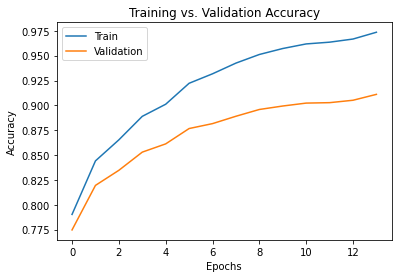

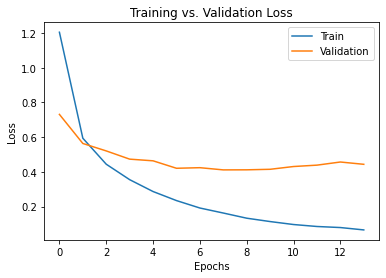

In [0]:
train(resnet_model, train_loader, validation_loader, num_epochs=14, learning_rate=0.001)

### Results

In [0]:
path_test = get_model_name(resnet_model.name, batch_size=128, learning_rate=0.001, epoch=9)

In [0]:
model = resnet18(1, 348)
# Load in its weights
model.load_state_dict(torch.load(path_test))

<All keys matched successfully>

In [0]:
model.cuda()

In [0]:
model.eval()

In [0]:
get_accuracy(model, validation_loader)

0.9032840722495895

In [0]:
get_accuracy(model, test_loader)

0.9038793103448276

In [0]:
true_states, pred_states = prepare_full_accuracy(model, test_loader)

In [0]:
all_accuracy_dict = full_accuracy_totals(true_states, pred_states)

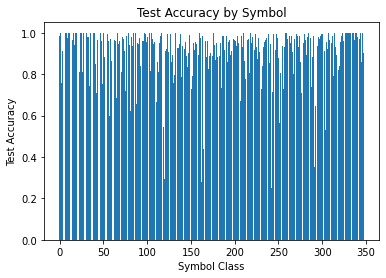

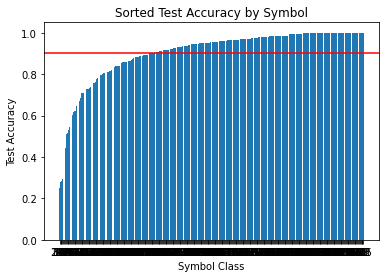

In [0]:
plot_accuracy(all_accuracy_dict, 0.9038793103448276)

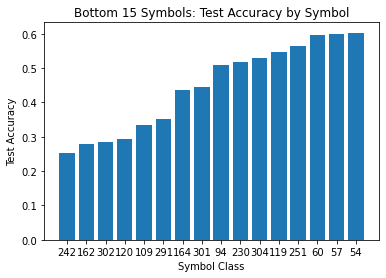

In [0]:
worst = plot_X_accuracy(all_accuracy_dict, 15, "Bottom")

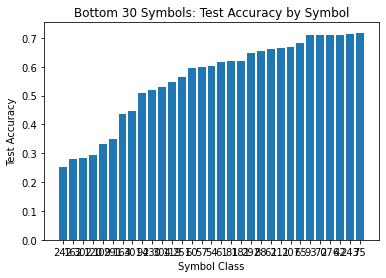

In [0]:
worst = plot_X_accuracy(all_accuracy_dict, 30, "Bottom")

In [0]:
matrix = confusion_matrix(true_states, pred_states, normalize='true')

In [0]:
for i in worst:
  get_single_confusion(matrix, i)


This symbol is:  \phi

Confusion analysis:

{'\\O': 0.0611, '\\Phi': 0.2214, '\\beta': 0.0076, '\\emptyset': 0.2061, '\\mathcal{G}': 0.0076, '\\mathcal{O}': 0.0076, '\\mathds{C}': 0.0076, '\\o': 0.0305, '\\oint': 0.0076, '\\oplus': 0.0076, '\\phi': 0.2519, '\\psi': 0.0076, '\\varnothing': 0.1374, '\\varphi': 0.0382}

This symbol is:  \mapsto

Confusion analysis:

{'\\celsius': 0.0082, '\\longmapsto': 0.6885, '\\mapsto': 0.2787, '\\mathcal{P}': 0.0082, '\\models': 0.0082, '\\sigma': 0.0082}

This symbol is:  \varepsilon

Confusion analysis:

{'\\Phi': 0.0068, '\\Sigma': 0.0068, '\\circledcirc': 0.0068, '\\epsilon': 0.0608, '\\mathcal{E}': 0.5743, '\\mathds{C}': 0.0068, '\\mathscr{E}': 0.0203, '\\mathsection': 0.0068, '\\notin': 0.0068, '\\pounds': 0.0068, '\\subseteq': 0.0068, '\\varepsilon': 0.2838, '\\vdots': 0.0068}

This symbol is:  \epsilon

Confusion analysis:

{'E': 0.0244, '\\Sigma': 0.0122, '\\delta': 0.0061, '\\epsilon': 0.2927, '\\in': 0.3476, '\\lesssim': 0.0122, '\\mathcal

In [0]:
sort_dictionary(all_accuracy_dict)

[(242, (0.2519, 33, 131, '\\phi')),
 (162, (0.2787, 34, 122, '\\mapsto')),
 (302, (0.2838, 42, 148, '\\varepsilon')),
 (120, (0.2927, 48, 164, '\\epsilon')),
 (109, (0.3333, 51, 153, '\\degree')),
 (291, (0.3504, 48, 137, '\\triangle')),
 (164, (0.4375, 56, 128, '\\mathbb{1}')),
 (301, (0.4453, 61, 137, '\\vDash')),
 (94, (0.5105, 73, 143, '\\circ')),
 (230, (0.518, 72, 139, '\\o')),
 (304, (0.5298, 80, 151, '\\varnothing')),
 (119, (0.5467, 82, 150, '\\emptyset')),
 (251, (0.5649, 74, 131, '\\propto')),
 (60, (0.597, 80, 134, '\\Pi')),
 (57, (0.5985, 82, 137, '\\O')),
 (54, (0.6031, 79, 131, '\\Lambda')),
 (61, (0.6176, 84, 136, '\\Psi')),
 (81, (0.6212, 82, 132, '\\beta')),
 (181, (0.6214, 87, 140, '\\mathcal{O}')),
 (292, (0.6467, 97, 150, '\\triangledown')),
 (88, (0.6547, 91, 139, '\\bullet')),
 (62, (0.6619, 92, 139, '\\Re')),
 (111, (0.6667, 84, 126, '\\diameter')),
 (207, (0.6691, 93, 139, '\\mathscr{L}')),
 (65, (0.6842, 104, 152, '\\Theta')),
 (93, (0.7095, 105, 148, '\\chi')

## ResNet-18 Final Model With Weight Decay

In [0]:
resnet_model = resnet18(1, 348)

In [0]:
use_cuda = True
resnet_model.cuda()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [0]:
resnet_model.train()

Training started...
Epoch #0, Training Loss: 1.1847, Validation Loss: 0.7441
Epoch #0, Training Accuracy: 0.7845, Validation Accuracy: 0.7677
Epoch #1, Training Loss: 0.5996, Validation Loss: 0.5847
Epoch #1, Training Accuracy: 0.8359, Validation Accuracy: 0.8124
Epoch #2, Training Loss: 0.4690, Validation Loss: 0.5330
Epoch #2, Training Accuracy: 0.8570, Validation Accuracy: 0.8284
Epoch #3, Training Loss: 0.3953, Validation Loss: 0.4952
Epoch #3, Training Accuracy: 0.8749, Validation Accuracy: 0.8421
Epoch #4, Training Loss: 0.3432, Validation Loss: 0.4645
Epoch #4, Training Accuracy: 0.8888, Validation Accuracy: 0.8527
Epoch #5, Training Loss: 0.3008, Validation Loss: 0.4616
Epoch #5, Training Accuracy: 0.8981, Validation Accuracy: 0.8584
Epoch #6, Training Loss: 0.2685, Validation Loss: 0.4500
Epoch #6, Training Accuracy: 0.9035, Validation Accuracy: 0.8615
Epoch #7, Training Loss: 0.2371, Validation Loss: 0.4345
Epoch #7, Training Accuracy: 0.9128, Validation Accuracy: 0.8681
Epoc

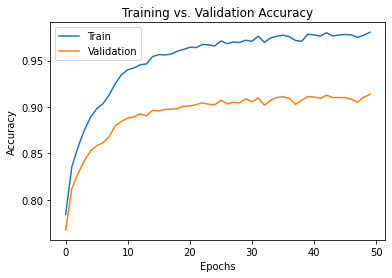

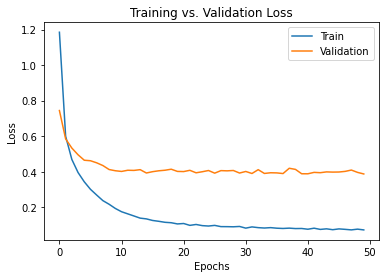

In [0]:
train(resnet_model, train_loader, validation_loader, num_epochs=50, learning_rate=0.001, weight_decay=0.0001)

Interesting results! Validation accuracy is lower, but the validation loss behaves better.

You can load this later in another session to generate results on the test set 

In [0]:
path_test = get_model_name(resnet_model.name, batch_size=128, learning_rate=0.001, epoch=49)

In [0]:
model = resnet18(1, 348)
# Load in its weights
model.load_state_dict(torch.load(path_test))

<All keys matched successfully>

In [0]:
model.cuda()

In [0]:
model.eval()

In [0]:
get_accuracy(model, test_loader)

0.9169950738916256